# Detrend and Estimate Noise

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.optimize as op
import scipy.signal as sig
from   scipy import stats
from   scipy import fftpack
from   scipy import ndimage
from   scipy.interpolate import UnivariateSpline
import astropy
from   astropy.io import fits as pyfits
from   sklearn.cluster import KMeans

import csv
import sys
import os
import importlib as imp
import glob
from   timeit import default_timer as timer
import warnings
import progressbar
import argparse
import json
from   copy import deepcopy

import lightkurve as lk
import exoplanet as exo
import theano.tensor as T
import pymc3 as pm
import corner

from alderaan.constants import *
from alderaan.utils import *
from alderaan.Planet import *
from alderaan.LiteCurve import *
import alderaan.io as io
import alderaan.detrend as detrend
import alderaan.noise as noise
from alderaan.omc import omc_model
from alderaan.omc import choose_omc_model


# flush buffer to avoid mixed outputs from progressbar
sys.stdout.flush()

# turn off FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# start program timer
global_start_time = timer()

# LCIT and SCIT in [1/days]
lcit = LCIT/60/24
scit = SCIT/3600/24

# Manually set I/O parameters
#### User should manually set MISSION, TARGET, PRIMARY_DIR,  and CSV_FILE
#### Note that if using DR25, you will need to manually correct epochs from BJD to BJKD with an offset of 2454833.0 days; the cumulative exoplanet archive catalog has already converted epochs to BJKD

In [2]:
# select mission, target, and paths
MISSION = "Kepler"
TARGET  = "K02086"

PRIMARY_DIR  = '/Users/research/projects/alderaan/'

CSV_FILE = PRIMARY_DIR + "Catalogs/cumulative_koi_catalog.csv"
BKJD_CORRECTION = 0.0

#CSV_FILE = PRIMARY_DIR + "Catalogs/clean_kepler_catalog.csv"
#BKJD_CORRECTION = 2454833.0


In [3]:
# here's where we parse the inputs
try:
    parser = argparse.ArgumentParser(description="Inputs for ALDERAAN transit fiting pipeline")
    parser.add_argument("--mission", default=None, type=str, required=True, \
                        help="Mission name")
    parser.add_argument("--target", default=None, type=str, required=True, \
                        help="Target name; see ALDERAAN documentation for acceptable formats")
    parser.add_argument("--primary_dir", default=None, type=str, required=True, \
                        help="Primary directory path for accessing lightcurve data and saving outputs")
    parser.add_argument("--csv_file", default=None, type=str, required=True, \
                        help="Path to .csv file containing input planetary parameters")


    args = parser.parse_args()
    MISSION      = args.mission
    TARGET       = args.target
    PRIMARY_DIR  = args.primary_dir
    CSV_FILE     = args.csv_file    
    
except:
    pass

usage: ipykernel_launcher.py [-h] --mission MISSION --target TARGET
                             --primary_dir PRIMARY_DIR --csv_file CSV_FILE
ipykernel_launcher.py: error: the following arguments are required: --mission, --target, --primary_dir, --csv_file


In [4]:
HOLCZER_FILE = PRIMARY_DIR + "Catalogs/holczer_2016_kepler_ttvs.txt"

# Make sure the necessary paths exist

In [5]:
# directory in which to find lightcurve data
if MISSION == 'Kepler': DOWNLOAD_DIR = PRIMARY_DIR + 'MAST_downloads/'
if MISSION == 'Simulated': DOWNLOAD_DIR = PRIMARY_DIR + 'Simulations/'

# directories in which to place pipeline outputs
FIGURE_DIR    = PRIMARY_DIR + 'Figures/' + TARGET + '/'
TRACE_DIR     = PRIMARY_DIR + 'Traces/' + TARGET + '/'
QUICK_TTV_DIR = PRIMARY_DIR + 'QuickTTVs/' + TARGET + '/'
DLC_DIR       = PRIMARY_DIR + 'Detrended_lightcurves/' + TARGET + '/'
NOISE_DIR     = PRIMARY_DIR + 'Noise_models/' + TARGET + '/'


# check if all the paths exist and create them if not
if os.path.exists(FIGURE_DIR) == False:
    os.mkdir(FIGURE_DIR)
    
if os.path.exists(TRACE_DIR) == False:
    os.mkdir(TRACE_DIR)
    
if os.path.exists(QUICK_TTV_DIR) == False:
    os.mkdir(QUICK_TTV_DIR)
    
if os.path.exists(DLC_DIR) == False:
    os.mkdir(DLC_DIR)
    
if os.path.exists(NOISE_DIR) == False:
    os.mkdir(NOISE_DIR)

# Read in planet and stellar parameters from Kepler DR25 & Gaia DR2

In [6]:
# Read in the data from csv file
print('Reading in data from csv file')

# read in a csv file containing info on targets
csv_keys, csv_values = io.read_csv_file(CSV_FILE)

# put these csv data into a dictionary
target_dict = {}
for k in csv_keys: 
    target_dict[k] = io.get_csv_data(k, csv_keys, csv_values)

    
if MISSION == 'Kepler':
    # pull relevant quantities and establish GLOBAL variables
    use = np.array(target_dict['koi_id']) == TARGET

    KIC = np.array(target_dict['kic_id'], dtype='int')[use]
    NPL = np.array(target_dict['npl'], dtype='int')[use]
    
    RSTAR = np.array(target_dict['rstar'],  dtype='float')[use]
    RSTAR_ERR1 = np.array(target_dict['rstar_err1'],  dtype='float')[use]
    RSTAR_ERR2 = np.array(target_dict['rstar_err2'],  dtype='float')[use]
    
    MSTAR  = np.array(target_dict['mstar'], dtype='float')[use]
    MSTAR_ERR1 = np.array(target_dict['mstar_err1'],  dtype='float')[use]
    MSTAR_ERR2 = np.array(target_dict['mstar_err2'],  dtype='float')[use]

    PERIODS = np.array(target_dict['period'], dtype='float')[use]
    EPOCHS  = np.array(target_dict['epoch'],  dtype='float')[use] - BKJD_CORRECTION
    DEPTHS  = np.array(target_dict['depth'], dtype='float')[use]*1e-6          # [ppm] --> []
    DURS    = np.array(target_dict['duration'], dtype='float')[use]/24         # [hrs] --> [days]

    
elif MISSION == 'Simulated':
    # pull relevant quantities and establish GLOBAL variables
    use = np.array(target_dict['id_sim']) == TARGET

    KIC    = np.array(target_dict['kic'], dtype='int')[use]
    NPL    = np.array(target_dict['npl'], dtype='int')[use]
    RSTAR  = np.array(target_dict['rstar'],  dtype='float')[use]
    MSTAR  = np.array(target_dict['mstar'], dtype='float')[use]

    PERIODS = np.array(target_dict['period'], dtype='float')[use]
    EPOCHS  = np.array(target_dict['epoch'],  dtype='float')[use]
    DEPTHS  = np.array(target_dict['depth'], dtype='float')[use]*1e-6     # [ppm] --> []
    DURS    = np.array(target_dict['dur'], dtype='float')[use]/24         # [hrs] --> [days]
        
    
else:
    raise ValueError("MISSION must be 'Kepler' or 'Simulated'")

Reading in data from csv file


In [7]:
# do some consistency checks
if all(k == KIC[0] for k in KIC): KIC = KIC[0]
else: raise ValueError('There are inconsistencies with KIC in the csv input file')

if all(n == NPL[0] for n in NPL): NPL = NPL[0]
else: raise ValueError('There are inconsistencies with NPL in the csv input file')

if all(r == RSTAR[0] for r in RSTAR): RSTAR = RSTAR[0]
else: raise ValueError('There are inconsistencies with RSTAR in the csv input file')

if all(r == RSTAR_ERR1[0] for r in RSTAR_ERR1): RSTAR_ERR1 = RSTAR_ERR1[0]
else: raise ValueError('There are inconsistencies with RSTAR_ERR1 in the csv input file')
    
if all(r == RSTAR_ERR2[0] for r in RSTAR_ERR2): RSTAR_ERR2 = RSTAR_ERR2[0]
else: raise ValueError('There are inconsistencies with RSTAR_ERR2 in the csv input file')  
    
if all(m == MSTAR[0] for m in MSTAR): MSTAR = MSTAR[0]
else: raise ValueError('There are inconsistencies with MSTAR in the csv input file')

if all(m == MSTAR_ERR1[0] for m in MSTAR_ERR1): MSTAR_ERR1 = MSTAR_ERR1[0]
else: raise ValueError('There are inconsistencies with MSTAR_ERR1 in the csv input file')
    
if all(m == MSTAR_ERR2[0] for m in MSTAR_ERR2): MSTAR_ERR2 = MSTAR_ERR2[0]
else: raise ValueError('There are inconsistencies with MSTAR_ERR2 in the csv input file')  

In [8]:
# combline stellar radius/mass uncertainties
MSTAR_ERR = np.sqrt(MSTAR_ERR1**2 + MSTAR_ERR2**2)/np.sqrt(2)
RSTAR_ERR = np.sqrt(RSTAR_ERR1**2 + RSTAR_ERR2**2)/np.sqrt(2)

#initialize with solar limb darkening coefficients from EXOFAST
U1 = 0.39940842
U2 = 0.26477268
UCOEFFS = [U1, U2]

In [9]:
bad = PERIODS > 100

PERIODS = PERIODS[~bad]
EPOCHS = EPOCHS[~bad]
DEPTHS = DEPTHS[~bad]
DURS = DURS[~bad]

NPL = len(PERIODS)

# Read in Holczer+ 2016 TTVs

In [10]:
if MISSION == "Kepler":
    holczer_data = np.loadtxt(HOLCZER_FILE, usecols=[0,1,2,3])

    holczer_inds = []
    holczer_tts  = []
    holczer_pers = []

    for npl in range(NPL):
        koi = int(TARGET[1:]) + 0.01*(1+npl)
        use = np.isclose(holczer_data[:,0], koi, rtol=1e-10, atol=1e-10)
        
        # Holczer uses BJD -24548900; BJKD = BJD - 2454833
        if np.sum(use) > 0:
            holczer_inds.append(np.array(holczer_data[use,1], dtype="int"))
            holczer_tts.append(holczer_data[use,2] + holczer_data[use,3]/24/60 + 67)
            holczer_pers.append(np.median(holczer_tts[npl][1:] - holczer_tts[npl][:-1]))
            
        else:
            holczer_inds.append(None)
            holczer_tts.append(None)
            holczer_pers.append(np.nan)
            
    holczer_pers = np.asarray(holczer_pers)

# Read in pre-downloaded lightcurve data
#### Kepler data can be retrieved by running the script "download_from_MAST.py"
#### Simulated data can be produced by running the script "simulate_lightcurve.py"

In [11]:
if MISSION == 'Kepler':
    # short cadence
    try:
        sc_path  = glob.glob(DOWNLOAD_DIR + 'mastDownload/Kepler/kplr' + '{0:09d}'.format(KIC) + '*_sc*/')[0]
        sc_files = glob.glob(sc_path + '*')

        sc_rawdata_list = []
        for i, scf in enumerate(sc_files):
            oscfi = lk.search.open(sc_files[i])
            sc_rawdata_list.append(oscfi)

        sc_rawdata = lk.LightCurveFileCollection(sc_rawdata_list)
        sc_data = detrend.cleanup_lkfc(sc_rawdata, KIC)

        sc_quarters = []
        for i, scd in enumerate(sc_data):
            sc_quarters.append(scd.quarter)
    
    except:
        sc_data = []
        sc_quarters = []
        

    # long cadence data
    lc_path  = glob.glob(DOWNLOAD_DIR + 'mastDownload/Kepler/kplr' + '{0:09d}'.format(KIC) + '*_lc*/')[0]
    lc_files = glob.glob(lc_path + '*')

    lc_rawdata_list = []
    for i, lcf in enumerate(lc_files):
        olcfi = lk.search.open(lc_files[i])
        
        if ~np.isin(olcfi.quarter, sc_quarters):
            lc_rawdata_list.append(olcfi)

    lc_rawdata = lk.LightCurveFileCollection(lc_rawdata_list)
    lc_data = detrend.cleanup_lkfc(lc_rawdata, KIC)
        
    lc_quarters = []
    for i, lcd in enumerate(lc_data):
        lc_quarters.append(lcd.quarter)
        
        
elif MISSION == 'Simulated':
    sc_files = glob.glob(DOWNLOAD_DIR + TARGET + '/*_sc.fits')
    lc_files = glob.glob(DOWNLOAD_DIR + TARGET + '/*_lc.fits')
    
    sc_rawdata_list = []
    for i, scf in enumerate(sc_files):
        sc_rawdata_list.append(io.read_sim_fits(scf))
    
    sc_rawdata = lk.LightCurveCollection(sc_rawdata_list)
    
    sc_quarters = []
    for i, scrd in enumerate(sc_rawdata):
        sc_quarters.append(scrd.quarter)
        
    order = np.argsort(sc_quarters)    
    sc_data = lk.LightCurveCollection([sc_rawdata_list[o] for o in order])
            
    
    lc_rawdata_list = []
    for i, lcf in enumerate(lc_files):      
        lc_rawdata_list.append(io.read_sim_fits(lcf))
    
    lc_rawdata = lk.LightCurveCollection(lc_rawdata_list)
    
    lc_quarters = []
    for i, lcrd in enumerate(lc_rawdata):
        lc_quarters.append(lcrd.quarter)
        
    order = np.argsort(lc_quarters)    
    lc_data = lk.LightCurveCollection([lc_rawdata_list[o] for o in order])

In [12]:
# determine the time baseline
time_min = []
time_max = []

try:
    for i, scd in enumerate(sc_data):
        time_min.append(scd.time.min())
        time_max.append(scd.time.max())
        
except:
    pass


try:
    for i, lcd in enumerate(lc_data):
        time_min.append(lcd.time.min())
        time_max.append(lcd.time.max())
        
except:
    pass
    
    
TIME_START = np.min(time_min)
TIME_END   = np.max(time_max)

if TIME_START < 0:
    raise ValueError("START TIME [BKJD] is negative...this will cause problems")


# put epochs in range (TIME_START, TIME_START + PERIOD)
for npl in range(NPL):
    if EPOCHS[npl] < TIME_START:
        adj = 1 + (TIME_START - EPOCHS[npl])//PERIODS[npl]
        EPOCHS[npl] += adj*PERIODS[npl]        
        
    if EPOCHS[npl] > (TIME_START + PERIODS[npl]):
        adj = (EPOCHS[npl] - TIME_START)//PERIODS[npl]
        EPOCHS[npl] -= adj*PERIODS[npl]

# Initialize Planet objects

In [13]:
# initialize Planet objects
print('Initializing %d Planet objects' %NPL)

planets = []
for npl in range(NPL):
    p = Planet()
    
    # put in some basic transit parameters
    p.epoch    = EPOCHS[npl]
    p.period   = PERIODS[npl]
    p.depth    = DEPTHS[npl]
    p.duration = DURS[npl]
    p.impact   = 0.25
    p.esinw    = np.sqrt(0.0355)*np.random.randn()
    p.ecosw    = np.sqrt(0.0355)*np.random.randn()
    
    # estimate transit times from linear ephemeris
    p.tts = np.arange(p.epoch, TIME_END, p.period)

    # make transit indexes
    p.index = np.array(np.round((p.tts-p.epoch)/p.period),dtype='int')
    
    # add to list
    planets.append(p)


# put planets in order by period
order = np.argsort(PERIODS)

sorted_planets = []
for npl in range(NPL):
    sorted_planets.append(planets[order[npl]])

planets = np.copy(sorted_planets)

Initializing 3 Planet objects


# Smooth and interpolate Holczer TTVs where they exist


PLANET 0

PLANET 1


optimizing logp for variables: [logvar, mean, log_rho, log_sigma]
40it [00:01, 30.66it/s, logp=2.850310e+02] 
message: Optimization terminated successfully.
logp: 220.199544801424 -> 285.03098474247093


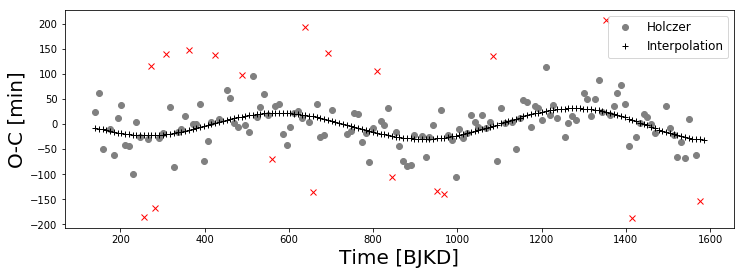


PLANET 2


In [14]:
for npl in range(NPL):
    print("\nPLANET", npl)
    try:
        # fit a linear ephemeris 
        pfit  = np.polyfit(holczer_inds[npl], holczer_tts[npl], 1)
        ephem = np.polyval(pfit, holczer_inds[npl])
        
        
        # put fitted epoch in range (TIME_START, TIME_START + PERIOD)
        hper, hepoch = pfit

        if hepoch < TIME_START:
            adj = 1 + (TIME_START - hepoch)//hper
            hepoch += adj*hper       

        if hepoch > (TIME_START + hper):
            adj = (hepoch - TIME_START)//hper
            hepoch -= adj*hper      

        hephem = np.arange(hepoch, TIME_END, hper)        
        hinds  = np.array(np.round((hephem-hepoch)/hper),dtype='int')
        
        
        # calculate OMC and flag outliers
        xtime = np.copy(holczer_tts[npl])
        yomc  = (holczer_tts[npl] - ephem)

        ymed = ndimage.median_filter(yomc, size=5, mode="mirror")
        out  = np.abs(yomc-ymed)/astropy.stats.mad_std(yomc-ymed) > 3.0
                
        # set up a GP using a Matern-3/2 kernel
        with pm.Model() as holczer_model:

            # build the kernel 
            log_sigma = pm.Normal("log_sigma", mu=np.log(np.std(yomc)), sd=10)
            log_rho = pm.Normal("log_rho", mu=np.log(xtime[1]-xtime[0]), sd=10)

            kernel = exo.gp.terms.Matern32Term(log_sigma=log_sigma, log_rho=log_rho)

            # nusiance parameters
            mean = pm.Normal("mean", mu=np.mean(yomc), sd=10)
            logvar = pm.Normal("logvar", mu=np.log(np.var(yomc)), sd=10)

            # here's the GP
            gp = exo.gp.GP(kernel, xtime[~out], T.exp(logvar)*T.ones(len(xtime[~out])))

            # add custom potential (log-prob fxn) with the GP likelihood
            pm.Potential("obs", gp.log_likelihood(yomc[~out] - mean))

            # track GP prediction
            gp_pred = pm.Deterministic("gp_pred", gp.predict(hephem))


        # find the MAP solution
        with holczer_model:
            holczer_map = exo.optimize(start=holczer_model.test_point)
            
        htts = hephem + holczer_map["mean"] + holczer_map["gp_pred"]

        holczer_inds[npl] = np.copy(hinds)
        holczer_tts[npl] = np.copy(htts)
            
            
        # plot the results
        plt.figure(figsize=(12,4))
        plt.plot(xtime[~out], yomc[~out]*24*60, 'o', c="grey", label="Holczer")
        plt.plot(xtime[out], yomc[out]*24*60, "rx")
        plt.plot(hephem, (htts-hephem)*24*60, "k+", label="Interpolation")
        plt.xlabel("Time [BJKD]", fontsize=20)
        plt.ylabel("O-C [min]", fontsize=20)
        plt.legend(fontsize=12)
        plt.savefig(FIGURE_DIR + TARGET + "_holczer_ttvs_" + str(npl) + ".pdf")
        plt.show()
            
            
    except:
        pass

In [15]:
# check if Holczer TTVs exist, and if so, replace the linear ephemeris
for npl, p in enumerate(planets):
    match = np.isclose(holczer_pers, p.period, rtol=0.1, atol=DURS.max())
    
    if np.sum(match) == 1:
        loc = np.squeeze(np.where(match))
    
        hinds = holczer_inds[loc]
        htts  = holczer_tts[loc]
        
        tt_delta = htts.min() - p.tts.min()
        ind_delta = int(np.floor((tt_delta + 0.5*p.period)/p.period))
        
        p.tts[hinds + ind_delta] = np.copy(htts)
        
    if np.sum(match) > 1:
        raise ValueError("Something has gone wrong matching periods between DR25 and Holczer+ 2016")    

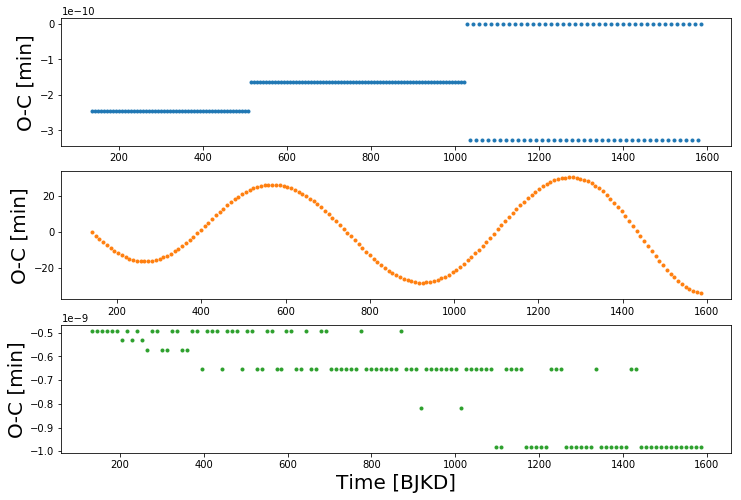

In [16]:
# plot the OMC TTVs
fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl, p in enumerate(planets):
    xtime = np.polyval(np.polyfit(p.index, p.tts, 1), p.index)
    yomc  = (p.tts - xtime)*24*60
    
    axes[npl].plot(xtime, yomc, '.', c='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.savefig(FIGURE_DIR + TARGET + '_ttvs_initial.pdf', bbox_inches='tight')
plt.show()

In [17]:
FULL_FIXED_EPHEMERIS = []
FULL_FIXED_INDS = []

for npl, p in enumerate(planets):
    FULL_FIXED_EPHEMERIS.append(np.polyval(np.polyfit(p.index, p.tts, 1), p.index))
    FULL_FIXED_INDS.append(np.copy(p.index - p.index.min()))    

# Detrend the lightcurves

In [18]:
# reset to raw data

if MISSION == 'Kepler':
    try:
        sc_data = detrend.cleanup_lkfc(sc_rawdata, KIC)

        sc_quarters = []
        for i, scd in enumerate(sc_data):
            sc_quarters.append(scd.quarter)    
    
    except:
        pass
    
    
    try:
        lc_data = detrend.cleanup_lkfc(lc_rawdata, KIC)

        lc_quarters = []
        for i, lcd in enumerate(lc_data):
            lc_quarters.append(lcd.quarter)
            
    except:
        pass
        

        
elif MISSION == 'Simulated':
    sc_quarters = []
    for i, scrd in enumerate(sc_rawdata):
        sc_quarters.append(scrd.quarter)
        
    order = np.argsort(sc_quarters)    
    sc_data = lk.LightCurveCollection([sc_rawdata_list[o] for o in order])
            

    lc_quarters = []
    for i, lcrd in enumerate(lc_rawdata):
        lc_quarters.append(lcrd.quarter)
        
    order = np.argsort(lc_quarters)    
    lc_data = lk.LightCurveCollection([lc_rawdata_list[o] for o in order])

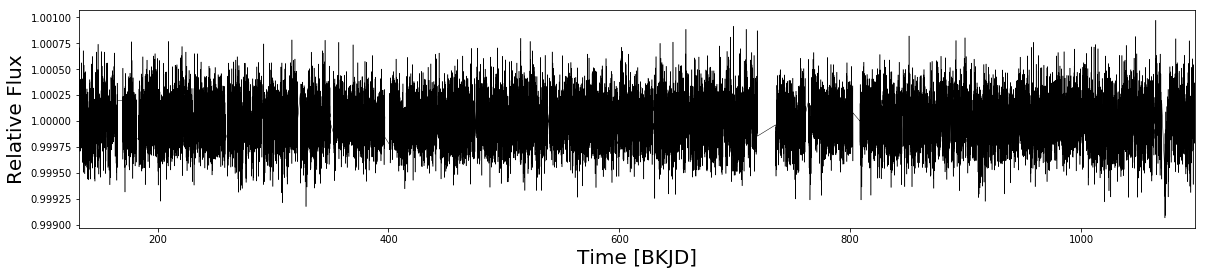

In [19]:
# clean up the LONG CADENCE data
for i, lcq in enumerate(lc_data):
    lcq = detrend.remove_flagged_cadences(lcq)
    lcq = detrend.clip_outliers(lcq, kernel_size=13, sigma_upper=5.0, sigma_lower=5.0)
    lc_data[i] = lcq

# broadcast quarter and channel integers into arrays (for convenient use after stitching)
for i, lcq in enumerate(lc_data):
    lcq.quarter = lcq.quarter*np.ones(len(lcq.time))
    lcq.channel = lcq.channel*np.ones(len(lcq.time))

    
if len(lc_data) > 0:
    # combine quarters into a single LiteCurve
    lc = detrend.stitch_lkc(lc_data)
    
    # make a mask where planets transit
    lc_mask = np.zeros((NPL,len(lc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        lc_mask[npl] = detrend.make_transitmask(lc.time, p.tts, p.duration, masksize=1.5)

    lc.mask = deepcopy(lc_mask)
    
    # plot the non-detrended data
    plt.figure(figsize=(20,4))
    plt.plot(lc.time, lc.flux, c="k", lw=0.5)
    plt.xlim(lc.time.min(), lc.time.max())
    plt.xlabel('Time [BKJD]', fontsize=20)
    plt.ylabel('Relative Flux', fontsize=20)
    plt.show()
    
else:
    lc = None

optimizing logp for variables: [logvar, flux0, exp_amp, logtau, mix, log_deltaQ, log_Q0_off, log_per_off, log_amp]
277it [00:03, 80.35it/s, logp=5.905996e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: 58028.15737729669 -> 59059.964748581966
optimizing logp for variables: [logvar, flux0, exp_amp, logtau, mix, log_deltaQ, log_Q0_off, log_per_off, log_amp]
314it [00:05, 56.36it/s, logp=7.857089e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: 76906.0750741734 -> 78570.89045687966
optimizing logp for variables: [logvar, flux0, exp_amp, logtau, mix, log_deltaQ, log_Q0_off, log_per_off, log_amp]
290it [00:04, 68.06it/s, logp=6.625656e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: 65031.53891574889 -> 66256.56190338187
optimizing logp for variables: [logvar, flux0, exp_amp, logtau, mix, log_deltaQ, log_Q0_off, log_per_off, log_amp]
290it [00:03, 73.17it/s, logp=5.907575e+04]
message: Desired

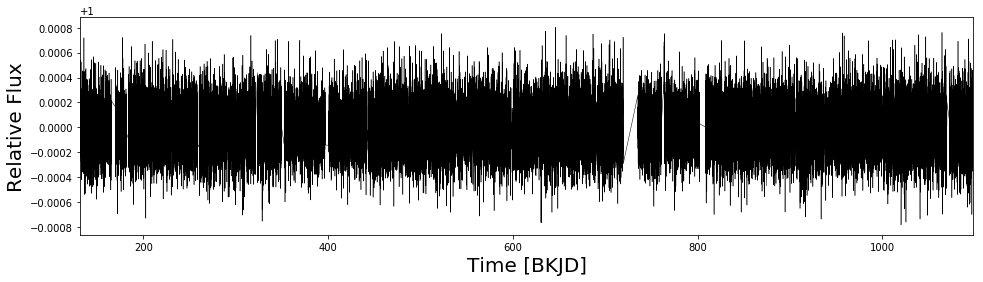

In [20]:
if lc is not None:    
    # detrend
    break_tolerance = int(DURS.max()/(LCIT/60/24)*5/2)
    min_period = 5*DURS.max()
    
    lc = detrend.flatten_with_gp(lc, break_tolerance=break_tolerance, min_period=min_period)

    # determine seasons
    lc.season = lc.quarter % 4

    # plot detrended data
    plt.figure(figsize=(16,4))
    plt.plot(lc.time, lc.flux, c='k', lw=0.5)
    plt.xlim(lc.time.min(), lc.time.max())
    plt.xlabel('Time [BKJD]', fontsize=20)
    plt.ylabel('Relative Flux', fontsize=20)
    plt.savefig(FIGURE_DIR + TARGET + '_long_cadence_flux.pdf', bbox_inches='tight')
    plt.show()

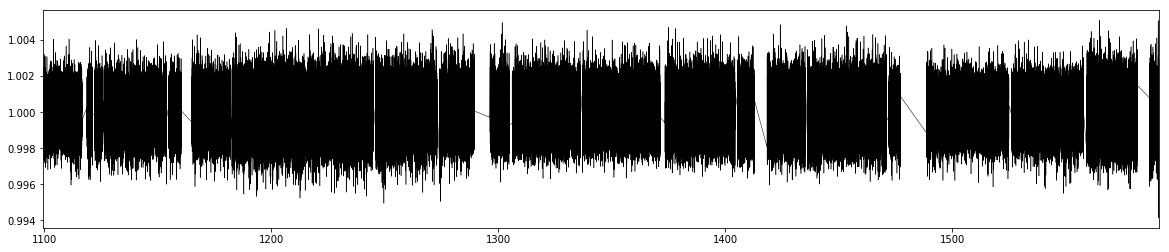

In [21]:
# clean up the SHORT CADENCE data
for i, scq in enumerate(sc_data):
    scq = detrend.remove_flagged_cadences(scq)
    scq = detrend.clip_outliers(scq, kernel_size=13, sigma_upper=5.0, sigma_lower=5.0)
    sc_data[i] = scq

# broadcast quarter and channel integers into arrays (for convenient use after stitching)
for i, scq in enumerate(sc_data):
    scq.quarter = scq.quarter*np.ones(len(scq.time))
    scq.channel = scq.channel*np.ones(len(scq.time))

    
if len(sc_data) > 0:
    # combine quarters into a single LiteCurve
    sc = detrend.stitch_lkc(sc_data)
    
    # make a mask where planets transit
    sc_mask = np.zeros((NPL,len(sc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        sc_mask[npl] = detrend.make_transitmask(sc.time, p.tts, p.duration, masksize=1.5)

    sc.mask = deepcopy(sc_mask)
    
    # plot the non-detrended data
    plt.figure(figsize=(20,4))
    plt.plot(sc.time, sc.flux, c="k", lw=0.5)
    plt.xlim(sc.time.min(), sc.time.max())
    plt.show()
    
else:
    sc = None

optimizing logp for variables: [logvar, flux0, exp_amp, logtau, mix, log_deltaQ, log_Q0_off, log_per_off, log_amp]
317it [00:46,  6.67it/s, logp=9.114474e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 909843.5984736894 -> 911447.3847035697
optimizing logp for variables: [logvar, flux0, exp_amp, logtau, mix, log_deltaQ, log_Q0_off, log_per_off, log_amp]
226it [00:38,  5.77it/s, logp=1.041183e+06]
message: Desired error not necessarily achieved due to precision loss.
logp: 1039379.1494952182 -> 1041183.4749428041
optimizing logp for variables: [logvar, flux0, exp_amp, logtau, mix, log_deltaQ, log_Q0_off, log_per_off, log_amp]
295it [00:50,  5.65it/s, logp=1.045166e+06]
message: Desired error not necessarily achieved due to precision loss.
logp: 1043344.3813093508 -> 1045165.5604836423


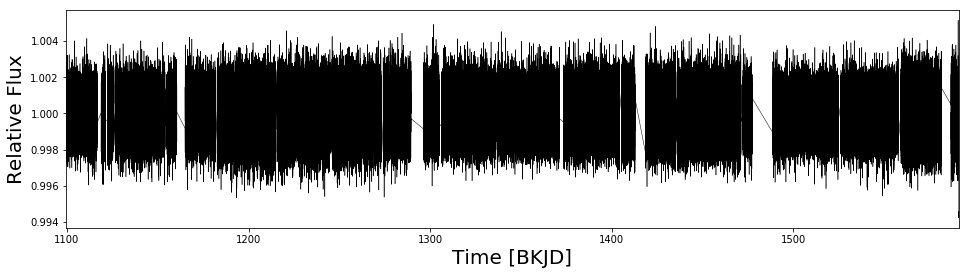

In [22]:
if sc is not None:    
    # detrend
    break_tolerance = int(DURS.max()/(SCIT/3600/24)*5/2)
    min_period = 5*DURS.max()
    
    sc = detrend.flatten_with_gp(sc, break_tolerance=break_tolerance, min_period=min_period)

    # determine seasons
    sc.season = sc.quarter % 4

    # plot detrended data
    plt.figure(figsize=(16,4))
    plt.plot(sc.time, sc.flux, c='k', lw=0.5)
    plt.xlim(sc.time.min(), sc.time.max())
    plt.xlabel('Time [BKJD]', fontsize=20)
    plt.ylabel('Relative Flux', fontsize=20)
    plt.savefig(FIGURE_DIR + TARGET + '_short_cadence_flux.pdf', bbox_inches='tight')
    plt.show()

# Make individual mask for where each planet transits
### These masks have width 1.5 transit durations, which may be wider than the masks used for detrending

In [23]:
print('Making transit masks')
try:
    sc_mask = np.zeros((NPL,len(sc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        sc_mask[npl] = detrend.make_transitmask(sc.time, p.tts, p.duration, masksize=1.5)

    sc.mask = sc_mask

except:
    sc_mask = None

    
try:
    lc_mask = np.zeros((NPL,len(lc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        lc_mask[npl] = detrend.make_transitmask(lc.time, p.tts, p.duration, masksize=1.5)
    
    lc.mask = lc_mask

except:
    lc_mask = None

Making transit masks


# Flag which transits have photometry coverage (quality = 1)

In [24]:
for npl, p in enumerate(planets):

    quality = []

    # cut out the stamps
    for i, t0 in enumerate(p.tts):
        try:
            neartransit_sc = np.abs(sc.time - t0)/p.duration < 1.5
            neartransit_lc = np.abs(lc.time - t0)/p.duration < 1.5
        
            quality.append((np.sum(neartransit_sc) + np.sum(neartransit_lc)) > 0)
                        
        except:
            neartransit = np.abs(lc.time - t0)/p.duration < 1.5
            quality.append(np.sum(neartransit) > 0)
        
    p.quality = np.copy(quality)

# Flag which transits overlap (overlap = 1)

In [25]:
# identify overlapping transits
dur_max = np.max(DURS)
overlap = []

for i in range(NPL):
    overlap.append(np.zeros(len(planets[i].tts), dtype='bool'))
    
    for j in range(NPL):
        if i != j:
            for ttj in planets[j].tts:
                overlap[i] += np.abs(planets[i].tts - ttj) < dur_max
                
    planets[i].overlap = np.copy(overlap[i])

# Count up transits and calculate initial fixed transit times

In [26]:
num_transits  = np.zeros(NPL)
transit_inds  = []
fixed_tts = []

for npl, p in enumerate(planets):
    transit_inds.append((p.index - p.index.min())[p.quality])
    fixed_tts.append(np.copy(p.tts)[p.quality])
    
    num_transits[npl] = len(transit_inds[npl])

# Grab the relevant data and starting transit parameters

In [27]:
# grab data near transits for each quarter
all_time = []
all_flux = []
all_error = []
all_dtype = []

lc_flux = []
sc_flux = []

if sc is not None:
    for q in range(18):
        if np.isin(q, sc.quarter)*np.isin(q, lc.quarter):
            raise ValueError("Double counting data in both short and long cadence")


        elif np.isin(q, sc.quarter):
            use = (sc.mask.sum(axis=0) > 0)*(sc.quarter == q)

            if np.sum(use) > 45:
                all_time.append(sc.time[use])
                all_flux.append(sc.flux[use])
                all_error.append(sc.error[use])
                all_dtype.append('short')

                sc_flux.append(sc.flux[use])
                
            else:
                all_time.append(None)
                all_flux.append(None)
                all_error.append(None)
                all_dtype.append('none')


        elif np.isin(q, lc.quarter):
            use = (lc.mask.sum(axis=0) > 0)*(lc.quarter == q)
            
            if np.sum(use) > 3:
                all_time.append(lc.time[use])
                all_flux.append(lc.flux[use])
                all_error.append(lc.error[use])
                all_dtype.append('long')

                lc_flux.append(lc.flux[use])
                
            else:
                all_time.append(None)
                all_flux.append(None)
                all_error.append(None)
                all_dtype.append('none')


        else:
            all_time.append(None)
            all_flux.append(None)
            all_error.append(None)
            all_dtype.append('none')
            
else:
    for q in range(18):
        if np.isin(q, lc.quarter):
            use = (lc.mask.sum(axis=0) > 0)*(lc.quarter == q)

            if np.sum(use) > 3:
                all_time.append(lc.time[use])
                all_flux.append(lc.flux[use])
                all_error.append(lc.error[use])
                all_dtype.append('long')

                lc_flux.append(lc.flux[use])
                
            else:
                all_time.append(None)
                all_flux.append(None)
                all_error.append(None)
                all_dtype.append('none')


        else:
            all_time.append(None)
            all_flux.append(None)
            all_error.append(None)
            all_dtype.append('none')



# check which quarters have data
good = (np.array(all_dtype) == 'short') + (np.array(all_dtype) == 'long')
quarters = np.arange(18)[good]
nq = len(quarters)


# make some linear flux arrays (for convenience use laster)
try: sc_flux_lin = np.hstack(sc_flux)
except: sc_flux_lin = np.array([])
    
try: lc_flux_lin = np.hstack(lc_flux)
except: lc_flux_lin = np.array([])
    
try:
    good_flux = np.hstack([sc_flux_lin, lc_flux_lin])
except:
    try:
        good_flux = np.hstack(sc_flux)
    except:
        good_flux = np.hstack(lc_flux)

In [28]:
# pull basic transit parameters
epochs    = np.zeros(NPL)
periods   = np.zeros(NPL)
depths    = np.zeros(NPL)
durations = np.zeros(NPL)
impacts   = np.zeros(NPL)

for npl, p in enumerate(planets):
    epochs[npl]    = p.epoch
    periods[npl]   = p.period
    depths[npl]    = p.depth
    durations[npl] = p.duration
    impacts[npl]   = p.impact

radii = np.sqrt(depths)*RSTAR

In [29]:
print('')
print('cumulative runtime = ', int(timer() - global_start_time), 's')
print('')


cumulative runtime =  314 s



# (1) Fit transit SHAPE model

The TTV model when determining transit shape is built as perturbations from fixed (i.e. invariant) transit times. These transit times ("FIXED_TTS") are not varied during model fitting. If TTVs are available from Holczer+ 2016, these are used; if not, the fixed transit times determined from a linear ephemeris using Kepler pipeline epoch and period.

Long-term, secular TTVs are parameterized as Legendre polynomials as functions of dimensionless variable ("x") in the range (-1,1)

Unlike the transit time and index values attached to each Planet object, there may be gaps in the FIXED_TTS vector where there is no available photometric data.

In [30]:
print('\n(1) Fitting transit SHAPE model')


(1) Fitting transit SHAPE model


In [31]:
# use Legendre polynomials for better orthogonality; "x" is in the range (-1,1)
Leg0 = []
Leg1 = []
Leg2 = []
Leg3 = []
t = []

# this assumes a baseline in the range (TIME_START,TIME_END)
for npl, p in enumerate(planets):    
    t.append(p.epoch + transit_inds[npl]*p.period)
    x = 2*(t[npl]-TIME_START)/(TIME_END-TIME_START) - 1

    Leg0.append(np.ones_like(x))
    Leg1.append(x.copy())
    Leg2.append(0.5*(3*x**2 - 1))
    Leg3.append(0.5*(5*x**3 - 3*x))

In [32]:
with pm.Model() as shape_model:
    # stellar parameters (limb darkening using Kipping 2013)
    u = exo.distributions.QuadLimbDark('u', testval=np.array([U1,U2]))

    Rstar = pm.Bound(pm.Normal, lower=RSTAR-3*RSTAR_ERR, upper=RSTAR+3*RSTAR_ERR)('Rstar', mu=RSTAR, sd=RSTAR_ERR)
    Mstar = pm.Bound(pm.Normal, lower=MSTAR-3*MSTAR_ERR, upper=MSTAR+3*MSTAR_ERR)('Mstar', mu=MSTAR, sd=MSTAR_ERR)

    
    # planetary parameters (impact parameter using Espinoza 2018)
    logr = pm.Uniform('logr', lower=np.log(0.0003), upper=np.log(0.3), testval=np.log(radii), shape=NPL)
    rp   = pm.Deterministic('rp', T.exp(logr))
    
    b  = exo.distributions.ImpactParameter('b', ror=rp/Rstar, testval=impacts, shape=NPL)
    
    
    # polynomial TTV parameters    
    C0 = pm.Normal('C0', mu=0.0, sd=durations/2, shape=NPL)
    C1 = pm.Normal('C1', mu=0.0, sd=durations/2, shape=NPL)
    
    transit_times = []
    for npl in range(NPL):
        transit_times.append(pm.Deterministic('tts_{0}'.format(npl), \
                                              fixed_tts[npl] + C0[npl]*Leg0[npl] + C1[npl]*Leg1[npl]))
    
    
    # set up stellar model and planetary orbit
    exoSLC = exo.StarryLightCurve(u)
    orbit  = exo.orbits.TTVOrbit(transit_times=transit_times, transit_inds=transit_inds, \
                                 b=b, r_star=Rstar, m_star=Mstar)
    
    # track period and epoch
    T0 = pm.Deterministic('T0', orbit.t0)
    P  = pm.Deterministic('P', orbit.period)
    
    
    # nuissance parameters
    flux0 = pm.Normal('flux0', mu=1.0, sd=np.std(good_flux))

    if len(sc_flux_lin) > 1:
        logvar = pm.Normal('logvar', mu=np.log(np.var(sc_flux_lin)), sd=np.log(4))
    else:
        logvar = pm.Normal('logvar', mu=np.log(np.var(lc_flux_lin)*30), sd=np.log(4))
    
    
    # now evaluate the model for each quarter
    light_curves       = [None]*nq
    summed_light_curve = [None]*nq
    model_flux         = [None]*nq
    
    obs = [None]*nq
    
    
    for j, q in enumerate(quarters):
        # set oversampling factor
        if all_dtype[q] == 'short':
            oversample = 1
        elif all_dtype[q] == 'long':
            oversample = 15
            
        # calculate light curves
        light_curves[j] = exoSLC.get_light_curve(orbit=orbit, r=rp, t=all_time[q], oversample=oversample)
        summed_light_curve[j] = pm.math.sum(light_curves[j], axis=-1) + flux0*T.ones(len(all_time[q]))
        model_flux[j] = pm.Deterministic('model_flux_{0}'.format(j), summed_light_curve[j])
        

        if all_dtype[q] == 'short':
            obs[j] = pm.Normal("obs_{0}".format(j), 
                               mu=model_flux[j], 
                               sd=T.sqrt(T.exp(logvar)),
                               observed=all_flux[q])
        
        elif all_dtype[q] == 'long':
            obs[j] = pm.Normal("obs_{0}".format(j), 
                               mu=model_flux[j], 
                               sd=T.sqrt(T.exp(logvar)/30),
                               observed=all_flux[q])
            
        else:
            raise ValueError("Cadence data type must be 'short' or 'long'")


In [33]:
with shape_model:
    shape_map = exo.optimize(start=shape_model.test_point, vars=[flux0, logvar])
    shape_map = exo.optimize(start=shape_map, vars=[b])
    shape_map = exo.optimize(start=shape_map, vars=[u, Mstar])
    shape_map = exo.optimize(start=shape_map, vars=[C0, C1])
    shape_map = exo.optimize(start=shape_map)

optimizing logp for variables: [logvar, flux0]
73it [00:07,  9.25it/s, logp=6.146648e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 614563.0630025659 -> 614664.7920747915
optimizing logp for variables: [b, logr, Rstar]
102it [00:06, 17.19it/s, logp=6.148677e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 614664.7920747915 -> 614867.6683798326
optimizing logp for variables: [Mstar, u]
22it [00:01, 16.12it/s, logp=6.148734e+05]
message: Optimization terminated successfully.
logp: 614867.6683798326 -> 614873.3635164484
optimizing logp for variables: [C1, C0]
160it [00:11, 13.91it/s, logp=6.148763e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 614873.3635164484 -> 614876.2536354013
optimizing logp for variables: [logvar, flux0, C1, C0, b, logr, Mstar, Rstar, u]
120it [00:09, 12.99it/s, logp=6.149449e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 614876.

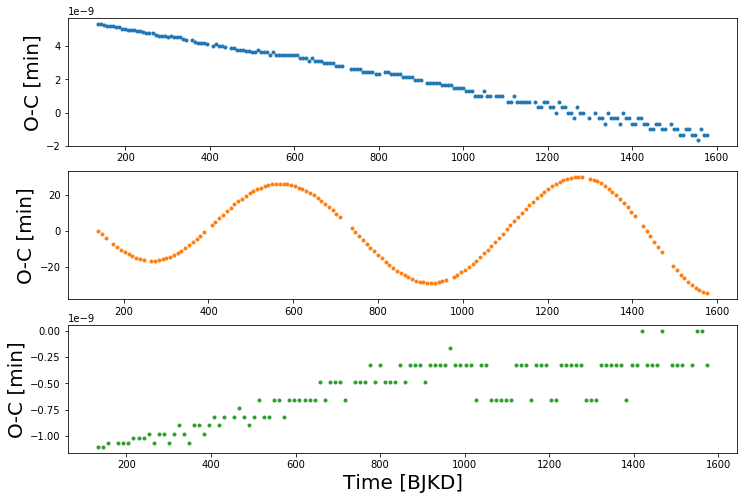

In [34]:
# grab transit times and ephemeris
shape_transit_times = []
shape_ephemeris = []

for npl, p in enumerate(planets):
    shape_transit_times.append(shape_map['tts_{0}'.format(npl)])
    shape_ephemeris.append(shape_map['P'][npl]*transit_inds[npl] + shape_map['T0'][npl])

    
# plot the OMC TTVs
fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl, p in enumerate(planets):
    xtime = shape_transit_times[npl]
    yomc  = (shape_transit_times[npl] - shape_ephemeris[npl])*24*60
    
    axes[npl].plot(xtime, yomc, '.', c='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.show()

In [35]:
print('')
print('cumulative runtime = ', int(timer() - global_start_time), 's')
print('')


cumulative runtime =  474 s



# (2) Fit independent TTVs

In [ ]:
print('\n(2) Fitting INDEPENDENT TTV model')

In [ ]:
rp = shape_map['rp']
b  = shape_map['b']

Rstar = shape_map['Rstar']
Mstar = shape_map['Mstar']
u = shape_map['u']

In [ ]:
with pm.Model() as indep_model:
    # transit times
    tt_offset = []
    transit_times = []
    
    for npl in range(NPL):
        tt_offset.append(pm.Normal('tt_offset_{0}'.format(npl), mu=0, sd=1, shape=len(shape_transit_times[npl])))
        
        transit_times.append(pm.Deterministic('tts_{0}'.format(npl), \
                                              shape_transit_times[npl] + tt_offset[npl]*durations[npl]/3))
    
    # set up stellar model and planetary orbit
    exoSLC = exo.StarryLightCurve(u)
    orbit  = exo.orbits.TTVOrbit(transit_times=transit_times, transit_inds=transit_inds, \
                                 b=b, r_star=Rstar, m_star=Mstar)
    
    # track period and epoch
    T0 = pm.Deterministic('T0', orbit.t0)
    P  = pm.Deterministic('P', orbit.period)
    
        
    # nuissance parameters
    flux0 = pm.Normal('flux0', mu=1.0, sd=np.std(good_flux))

    if len(sc_flux_lin) > 1:
        logvar = pm.Normal('logvar', mu=np.log(np.var(sc_flux_lin)), sd=np.log(4))
    else:
        logvar = pm.Normal('logvar', mu=np.log(np.var(lc_flux_lin)*30), sd=np.log(4))
    
    
    # now evaluate the model for each quarter
    light_curves       = [None]*nq
    summed_light_curve = [None]*nq
    model_flux         = [None]*nq
    
    obs = [None]*nq
    
    for j, q in enumerate(quarters):
        # set oversampling factor
        if all_dtype[q] == 'short':
            oversample = 1
        elif all_dtype[q] == 'long':
            oversample = 15
            
        # calculate light curves
        light_curves[j] = exoSLC.get_light_curve(orbit=orbit, r=rp, t=all_time[q], oversample=oversample)
        summed_light_curve[j] = pm.math.sum(light_curves[j], axis=-1) + flux0*T.ones(len(all_time[q]))
        model_flux[j] = pm.Deterministic('model_flux_{0}'.format(j), summed_light_curve[j])
        
        
        if all_dtype[q] == 'short':
            obs[j] = pm.Normal("obs_{0}".format(j), 
                               mu=model_flux[j], 
                               sd=T.sqrt(T.exp(logvar)),
                               observed=all_flux[q])
        
        elif all_dtype[q] == 'long':
            obs[j] = pm.Normal("obs_{0}".format(j), 
                               mu=model_flux[j], 
                               sd=T.sqrt(T.exp(logvar)/30),
                               observed=all_flux[q])
            
        else:
            raise ValueError("Cadence data type must be 'short' or 'long'")


In [ ]:
with indep_model:
    indep_map = exo.optimize(start=indep_model.test_point, vars=[flux0, logvar])
    
    for npl in range(NPL):
        indep_map = exo.optimize(start=indep_map, vars=[tt_offset[npl]])
        
    indep_map = exo.optimize(start=indep_map)

In [ ]:
indep_transit_times = []
indep_ephemeris = []
full_indep_ephemeris = []

for npl, p in enumerate(planets):
    indep_transit_times.append(indep_map['tts_{0}'.format(npl)])
    indep_ephemeris.append(indep_map['P'][npl]*transit_inds[npl] + indep_map['T0'][npl])
    full_indep_ephemeris.append(indep_map['P'][npl]*p.index + indep_map['T0'][npl])
    
    
fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl, p in enumerate(planets):
    xtime = indep_transit_times[npl]
    yomc  = (indep_transit_times[npl] - indep_ephemeris[npl])*24*60
    
    axes[npl].plot(xtime, yomc, '.', c='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.savefig(FIGURE_DIR + TARGET + '_ttvs_quick.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# get estimate of ttv amplitude and a reasonable buffer
ttv_amps   = np.zeros(NPL)
ttv_buffer = np.zeros(NPL)

for npl in range(NPL):
    # estimate TTV amplitude
    ttv_amps[npl] = astropy.stats.mad_std(indep_transit_times[npl] - indep_ephemeris[npl])

    # based on scatter in independent times, set threshold so not even one outlier is expected
    N   = len(transit_inds[npl])
    eta = np.max([3., stats.norm.interval((N-1)/N)[1]])

    ttv_buffer[npl] = eta*ttv_amps[npl]

In [ ]:
# Save fixed ephemeris and independent TTV measurements to a text file
for npl in range(NPL):
    data_out = np.vstack([transit_inds[npl], indep_ephemeris[npl]]).swapaxes(0,1)
    fname_out = QUICK_TTV_DIR + TARGET + "_{:02d}".format(npl) + "_fixed_ephemeris.txt"
    
    np.savetxt(fname_out, data_out, fmt=('%1d', '%.8f'), delimiter='\t')
    
    
    data_out  = np.vstack([transit_inds[npl], indep_transit_times[npl]]).swapaxes(0,1)
    fname_out = QUICK_TTV_DIR + TARGET + '_{:02d}'.format(npl) + '_map_indep_ttvs.txt'
    
    np.savetxt(fname_out, data_out, fmt=('%1d', '%.8f'), delimiter='\t')

In [ ]:
print('')
print('cumulative runtime = ', int(timer() - global_start_time), 's')
print('')

# Fit transits one-by-one

In [36]:
print("(3) Fitting transits ONE-BY-ONE")

(3) Fitting transits ONE-BY-ONE


In [37]:
rp = shape_map['rp']
b  = shape_map['b']

Rstar = shape_map['Rstar']
Mstar = shape_map['Mstar']
u = shape_map['u']

In [38]:
single_tts  = []

for npl, p in enumerate(planets):
    print("\nPLANET", npl)
    
    single_tts.append([])
    
    for i, t0 in enumerate(p.tts[p.quality*~p.overlap]):
        
        print(i, np.round(t0,2))

        # first grab the photometry data
        if sc is not None:
            use_sc = np.abs(sc.time - t0) < 1.5*p.duration

        if lc is not None:
            use_lc = np.abs(lc.time - t0) < 1.5*p.duration


        if (np.sum(use_sc) > 0)*(np.sum(use_lc) > 0):
            raise ValueError("Double counting data in both short and long cadence")

        elif np.sum(use_sc) > 0:
            xtime = sc.time[use_sc]
            yflux = sc.flux[use_sc]
            dtype = "short"

        elif np.sum(use_lc) > 0:
            xtime = lc.time[use_lc]
            yflux = lc.flux[use_lc]
            dtype = "long"

        else:
            raise ValueError("Expected either short or long cadence data")


        # next set up the model
        with pm.Model() as single_model:
            # single phyisical parameter (epoch)
            T0 = pm.Normal("T0", mu=t0, sd=p.duration/3)

            # nuissance parameters
            flux0 = pm.Normal("flux0", mu=1.0, sd=np.std(yflux))
            logvar = pm.Normal("logvar", mu=np.log(np.var(yflux)), sd=np.log(4))


            # set up stellar model and planetary orbit
            exoSLC = exo.StarryLightCurve(u)
            orbit  = exo.orbits.KeplerianOrbit(period=periods[npl], t0=T0, b=b[npl], 
                                               r_star=Rstar, m_star=Mstar)

            # set oversampling factor
            if dtype == 'short':
                oversample = 1
            elif dtype == 'long':
                oversample = 15

            # calculate light curves
            light_curves = exoSLC.get_light_curve(orbit=orbit, r=radii[npl], t=xtime, oversample=oversample)
            summed_light_curve = pm.math.sum(light_curves, axis=-1) + flux0*T.ones(len(xtime))
            model_flux = pm.Deterministic('model_flux', summed_light_curve)


            # here's the likelihood
            obs = pm.Normal("obs", mu=model_flux, sd=T.sqrt(T.exp(logvar)), observed=yflux)


        with single_model:
            single_trace = pm.sample(tune=1000, draws=500, start=single_model.test_point, chains=2, 
                                     step=exo.get_dense_nuts_step(target_accept=0.65))


        single_tts[npl].append((np.median(single_trace["T0"]), np.std(single_trace["T0"])))


PLANET 0
0 135.99


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 463.70draws/s] 


1 143.13


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 400.60draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


2 150.26


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 410.48draws/s]


3 157.39


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 372.75draws/s]
The number of effective samples is smaller than 25% for some parameters.


4 164.52


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 401.08draws/s]


5 171.66


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 494.75draws/s] 


6 178.79


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 493.52draws/s] 


7 185.92


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 464.15draws/s] 
The number of effective samples is smaller than 25% for some parameters.


8 193.06


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 466.21draws/s] 


9 200.19


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 274.65draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


10 207.32


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 347.22draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


11 214.46


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 438.20draws/s]


12 221.59


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 428.25draws/s]


13 228.72


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 304.01draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


14 235.85


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 393.23draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


15 242.99


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 488.46draws/s] 


16 250.12


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 463.60draws/s] 


17 257.25


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 447.70draws/s] 
The number of effective samples is smaller than 25% for some parameters.


18 271.52


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 496.75draws/s] 


19 278.65


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 391.92draws/s]


20 285.78


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 486.74draws/s] 


21 292.92


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 535.31draws/s] 


22 307.18


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 505.68draws/s] 


23 314.32


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 427.73draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


24 321.45


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 441.63draws/s] 
The number of effective samples is smaller than 25% for some parameters.


25 328.58


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 485.75draws/s] 


26 342.85


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 440.87draws/s] 


27 357.11


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 469.71draws/s] 


28 364.25


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 507.66draws/s] 


29 378.51


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 505.38draws/s] 


30 385.65


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 440.24draws/s]


31 392.78


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 461.05draws/s] 


32 414.18


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 460.67draws/s] 


33 421.31


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 451.48draws/s] 


34 428.44


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 433.69draws/s] 


35 435.58


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 497.29draws/s] 


36 449.84


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 382.30draws/s]
The number of effective samples is smaller than 25% for some parameters.


37 456.98


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 529.72draws/s] 


38 464.11


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 500.84draws/s] 


39 471.24


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 542.61draws/s] 


40 485.51


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 360.73draws/s]
The number of effective samples is smaller than 25% for some parameters.


41 492.64


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 531.40draws/s] 


42 499.77


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 416.16draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


43 506.91


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 495.95draws/s] 


44 521.17


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 388.68draws/s]
The number of effective samples is smaller than 25% for some parameters.


45 528.3


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 421.91draws/s]


46 535.44


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 354.07draws/s]


47 542.57


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 415.42draws/s]


48 556.84


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 435.74draws/s] 


49 563.97


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 382.03draws/s]
The number of effective samples is smaller than 25% for some parameters.


50 571.1


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 491.03draws/s] 


51 578.24


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 288.68draws/s]


52 592.5


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 282.14draws/s]


53 599.63


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:12<00:00, 235.84draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


54 606.77


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:16<00:00, 181.65draws/s]
The acceptance probability does not match the target. It is 0.5297089152257686, but should be close to 0.65. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


55 613.9


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 463.52draws/s] 


56 628.17


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 426.31draws/s]


57 635.3


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 299.62draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


58 642.43


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 436.38draws/s] 


59 649.56


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 471.41draws/s] 


60 656.7


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 355.97draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


61 663.83


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:12<00:00, 240.50draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


62 670.96


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 461.61draws/s] 


63 678.1


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 405.81draws/s] 


64 685.23


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 358.59draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


65 692.36


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 450.62draws/s] 


66 699.5


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 448.57draws/s] 


67 706.63


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 426.70draws/s]


68 713.76


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 446.97draws/s] 
The number of effective samples is smaller than 25% for some parameters.


69 735.16


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 428.09draws/s] 


70 742.29


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:12<00:00, 129.38draws/s]
The acceptance probability does not match the target. It is 0.5126581182853687, but should be close to 0.65. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


71 749.43


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 361.29draws/s]
The number of effective samples is smaller than 25% for some parameters.


72 756.56


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 308.68draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


73 763.69


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 518.62draws/s] 


74 770.82


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:13<00:00, 219.78draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


75 777.96


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 339.59draws/s]
The number of effective samples is smaller than 25% for some parameters.


76 785.09


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 382.90draws/s]
The number of effective samples is smaller than 25% for some parameters.


77 792.22


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 381.38draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


78 799.36


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 459.43draws/s] 


79 813.62


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 460.72draws/s] 


80 820.76


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 424.56draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


81 827.89


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 462.55draws/s] 


82 835.02


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 427.16draws/s]


83 842.15


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 452.13draws/s] 


84 849.29


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 458.26draws/s] 


85 856.42


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 460.13draws/s] 


86 863.55


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 428.09draws/s]
The number of effective samples is smaller than 25% for some parameters.


87 870.69


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 384.18draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


88 877.82


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 423.44draws/s]
The number of effective samples is smaller than 25% for some parameters.


89 884.95


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 456.63draws/s] 


90 892.08


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 426.31draws/s]


91 899.22


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 477.08draws/s] 


92 913.48


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 519.38draws/s] 


93 920.62


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 453.88draws/s] 
The number of effective samples is smaller than 25% for some parameters.


94 927.75


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 414.90draws/s]


95 934.88


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 406.00draws/s]


96 942.02


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 461.31draws/s] 
The number of effective samples is smaller than 25% for some parameters.


97 949.15


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 416.81draws/s]


98 956.28


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 383.62draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


99 963.41


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 453.00draws/s] 


100 970.55


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 412.89draws/s]
The number of effective samples is smaller than 25% for some parameters.


101 977.68


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 421.67draws/s]
The number of effective samples is smaller than 25% for some parameters.


102 984.81


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 461.33draws/s] 


103 991.95


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 329.75draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


104 999.08


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 480.42draws/s] 


105 1006.21


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 462.46draws/s] 


106 1013.35


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 304.17draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


107 1020.48


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 442.17draws/s] 


108 1027.61


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 458.48draws/s] 
The number of effective samples is smaller than 25% for some parameters.


109 1034.74


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 322.46draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


110 1041.88


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 313.59draws/s]
The number of effective samples is smaller than 25% for some parameters.


111 1049.01


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 491.70draws/s] 


112 1056.14


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 439.42draws/s] 


113 1063.28


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 466.73draws/s] 
The estimated number of effective samples is smaller than 200 for some parameters.


114 1077.54


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 509.15draws/s] 


115 1084.67


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 368.55draws/s]
The number of effective samples is smaller than 25% for some parameters.


116 1091.81


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 481.75draws/s] 


117 1106.07


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 316.55draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


118 1113.21


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 355.75draws/s]


119 1120.34


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 330.45draws/s]


120 1127.47


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 316.20draws/s]


121 1134.61


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 345.64draws/s]


122 1141.74


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 340.72draws/s]


123 1148.87


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 318.47draws/s]


124 1156.0


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 339.22draws/s]


125 1170.27


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 343.77draws/s]


126 1177.4


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:12<00:00, 241.42draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


127 1184.54


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 275.46draws/s]


128 1191.67


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:13<00:00, 222.51draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


129 1198.8


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:11<00:00, 263.36draws/s]


130 1205.93


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 289.34draws/s]


131 1213.07


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 325.29draws/s]


132 1220.2


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 316.64draws/s]


133 1227.33


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 314.95draws/s]


134 1234.47


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 295.93draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


135 1241.6


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:11<00:00, 258.30draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


136 1248.73


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 275.80draws/s]


137 1255.87


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 318.53draws/s]


138 1263.0


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 282.55draws/s]


139 1270.13


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 327.01draws/s]


140 1277.26


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:15<00:00, 191.72draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


141 1284.4


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:21<00:00, 139.09draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


142 1298.66


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:14<00:00, 207.84draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


143 1312.93


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:15<00:00, 195.33draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


144 1320.06


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:12<00:00, 237.95draws/s]


145 1327.19


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:14<00:00, 211.84draws/s]


146 1334.33


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:12<00:00, 236.87draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


147 1341.46


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 292.82draws/s]


148 1348.59


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:11<00:00, 265.09draws/s]


149 1355.73


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:22<00:00, 166.07draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


150 1362.86


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 297.44draws/s]


151 1369.99


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 293.88draws/s]


152 1377.13


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:15<00:00, 197.57draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


153 1384.26


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:11<00:00, 261.38draws/s]


154 1391.39


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:11<00:00, 255.67draws/s]


155 1398.52


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:14<00:00, 201.07draws/s]
The number of effective samples is smaller than 25% for some parameters.


156 1405.66


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:11<00:00, 267.94draws/s]


157 1412.79


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 282.20draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


158 1419.92


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:12<00:00, 244.51draws/s]


159 1427.06


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 299.01draws/s]


160 1434.19


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:17<00:00, 175.28draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


161 1441.32


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:16<00:00, 186.01draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


162 1448.45


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:18<00:00, 166.34draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


163 1455.59


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:13<00:00, 220.00draws/s]


164 1462.72


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:13<00:00, 222.55draws/s]


165 1469.85


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 335.15draws/s]


166 1476.99


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:14<00:00, 202.82draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


167 1491.25


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 315.53draws/s]


168 1498.39


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 292.39draws/s]
The number of effective samples is smaller than 25% for some parameters.


169 1505.52


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:13<00:00, 221.91draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


170 1512.65


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:19<00:00, 153.35draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


171 1519.78


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 272.78draws/s]


172 1526.92


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 295.31draws/s]


173 1534.05


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 310.47draws/s]


174 1541.18


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:14<00:00, 201.88draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


175 1548.32


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 348.80draws/s]


176 1555.45


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 303.64draws/s]


177 1562.58


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 295.36draws/s]
The number of effective samples is smaller than 25% for some parameters.


178 1569.71


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:13<00:00, 216.66draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


179 1576.85


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 328.53draws/s]



PLANET 1
0 140.08


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 459.45draws/s] 


1 148.99


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 437.57draws/s] 


2 157.91


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 460.73draws/s] 


3 175.75


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 418.74draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


4 184.67


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 406.95draws/s]


5 193.58


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 470.83draws/s] 


6 202.5


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 485.74draws/s] 


7 211.42


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 360.46draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


8 220.34


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 469.20draws/s] 


9 229.26


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 433.24draws/s]


10 238.18


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 387.44draws/s]
The number of effective samples is smaller than 25% for some parameters.


11 247.09


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 428.21draws/s] 


12 264.93


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 477.26draws/s] 


13 273.85


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:12<00:00, 242.69draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


14 282.77


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 369.61draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


15 291.69


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 476.31draws/s] 
The number of effective samples is smaller than 25% for some parameters.


16 300.61


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 498.78draws/s] 


17 309.53


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 433.39draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


18 318.45


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 407.81draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


19 327.37


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 423.24draws/s]


20 336.29


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 483.01draws/s] 


21 345.21


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 456.10draws/s] 


22 354.13


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 479.75draws/s] 


23 363.05


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 376.90draws/s]
The number of effective samples is smaller than 25% for some parameters.


24 371.97


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 465.46draws/s] 


25 380.89


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 492.15draws/s] 


26 389.81


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 458.81draws/s] 


27 407.65


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 380.96draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


28 416.57


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 463.44draws/s] 


29 425.49


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 372.54draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


30 434.41


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 429.80draws/s]


31 443.33


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 487.06draws/s] 
The number of effective samples is smaller than 25% for some parameters.


32 452.25


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 471.34draws/s] 


33 461.17


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 521.86draws/s] 


34 470.09


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 532.34draws/s] 
The estimated number of effective samples is smaller than 200 for some parameters.


35 479.01


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 509.23draws/s] 


36 487.93


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:11<00:00, 268.81draws/s]
The number of effective samples is smaller than 25% for some parameters.


37 496.85


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 472.63draws/s] 


38 505.77


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 470.80draws/s] 


39 514.69


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 395.77draws/s]


40 523.61


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 474.87draws/s] 


41 532.53


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 381.35draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


42 541.45


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 420.60draws/s]


43 550.37


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 466.23draws/s] 


44 559.29


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 406.36draws/s]


45 568.21


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 473.41draws/s] 


46 577.13


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 449.72draws/s] 


47 586.04


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 496.79draws/s] 


48 594.96


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 463.66draws/s] 


49 603.88


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 364.05draws/s]
The number of effective samples is smaller than 25% for some parameters.


50 612.8


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 478.59draws/s] 


51 621.72


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 432.12draws/s]


52 630.64


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 448.75draws/s] 


53 639.55


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 657.45draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


54 648.47


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 400.09draws/s]


55 657.39


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 391.90draws/s]


56 666.31


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 441.42draws/s]


57 675.23


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 421.56draws/s]


58 684.14


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 375.18draws/s]


59 693.06


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 437.33draws/s] 


60 701.98


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 460.45draws/s] 


61 710.9


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 361.42draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


62 737.65


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 436.24draws/s] 


63 746.57


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 455.35draws/s] 


64 755.49


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 501.01draws/s] 


65 764.4


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 415.40draws/s]


66 773.32


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 396.05draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


67 782.24


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 364.99draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


68 791.16


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 459.99draws/s] 


69 800.07


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 525.67draws/s] 


70 808.99


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 275.82draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


71 817.91


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 511.98draws/s] 


72 826.83


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 457.70draws/s] 


73 835.74


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 463.61draws/s] 


74 844.66


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 467.84draws/s] 


75 853.58


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 485.42draws/s] 
The acceptance probability does not match the target. It is 0.5401098489431375, but should be close to 0.65. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


76 862.5


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 466.93draws/s] 
The estimated number of effective samples is smaller than 200 for some parameters.


77 871.42


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 443.19draws/s] 


78 880.33


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 429.30draws/s] 
The number of effective samples is smaller than 25% for some parameters.


79 889.25


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 472.67draws/s] 


80 898.17


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 428.00draws/s]


81 907.09


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 474.57draws/s] 


82 916.01


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 474.01draws/s] 


83 924.93


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 491.28draws/s] 


84 933.85


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:04<00:00, 605.93draws/s] 


85 942.77


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 502.59draws/s] 


86 951.69


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 434.32draws/s]
The number of effective samples is smaller than 25% for some parameters.


87 960.6


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 503.91draws/s] 


88 978.44


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 533.42draws/s] 


89 987.36


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 499.01draws/s] 


90 996.28


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 444.44draws/s]


91 1005.2


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 457.21draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


92 1014.12


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 471.73draws/s]


93 1023.04


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 435.96draws/s]


94 1031.96


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 448.47draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


95 1040.88


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 486.88draws/s] 


96 1049.8


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 497.09draws/s] 


97 1058.73


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 443.16draws/s] 


98 1067.65


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 369.44draws/s]


99 1076.57


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 385.92draws/s]
The number of effective samples is smaller than 25% for some parameters.


100 1085.49


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 285.73draws/s]
The number of effective samples is smaller than 25% for some parameters.


101 1094.41


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 381.76draws/s] 
The number of effective samples is smaller than 25% for some parameters.


102 1103.33


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 349.43draws/s]


103 1112.25


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 322.68draws/s] 


104 1121.17


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:12<00:00, 241.33draws/s]
The acceptance probability does not match the target. It is 0.5432198958867067, but should be close to 0.65. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


105 1130.09


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 328.10draws/s]


106 1139.01


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:15<00:00, 199.33draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


107 1147.93


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 314.53draws/s]


108 1156.85


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 276.54draws/s]
The number of effective samples is smaller than 25% for some parameters.


109 1165.77


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:11<00:00, 269.91draws/s]


110 1174.69


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:12<00:00, 240.01draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


111 1183.61


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:12<00:00, 240.83draws/s]


112 1192.53


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 298.82draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


113 1201.45


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:11<00:00, 254.37draws/s]


114 1210.37


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:12<00:00, 242.08draws/s]
The number of effective samples is smaller than 25% for some parameters.


115 1219.29


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 319.28draws/s]


116 1228.21


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:12<00:00, 339.05draws/s]


117 1237.13


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:11<00:00, 254.44draws/s]


118 1246.05


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:13<00:00, 217.08draws/s]
The number of effective samples is smaller than 25% for some parameters.


119 1254.97


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:11<00:00, 256.42draws/s]
The number of effective samples is smaller than 25% for some parameters.


120 1263.89


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:13<00:00, 214.98draws/s]
The number of effective samples is smaller than 25% for some parameters.


121 1272.81


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:11<00:00, 269.31draws/s]


122 1281.73


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:11<00:00, 259.78draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


123 1308.48


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 303.68draws/s]


124 1317.4


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 322.82draws/s]


125 1326.32


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 274.77draws/s]


126 1344.16


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 479.41draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


127 1353.07


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 275.78draws/s]
The number of effective samples is smaller than 25% for some parameters.


128 1361.99


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:12<00:00, 247.89draws/s]


129 1379.83


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:15<00:00, 279.09draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


130 1388.74


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 287.52draws/s]
The number of effective samples is smaller than 25% for some parameters.


131 1397.66


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 328.51draws/s]


132 1424.41


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 294.28draws/s]


133 1433.33


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 316.68draws/s]


134 1451.16


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:11<00:00, 250.65draws/s]
The number of effective samples is smaller than 25% for some parameters.


135 1460.08


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 280.20draws/s]


136 1469.0


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 327.43draws/s]


137 1495.75


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 306.10draws/s]


138 1504.67


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 327.07draws/s]


139 1522.5


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 285.06draws/s]


140 1531.42


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 313.69draws/s]
The number of effective samples is smaller than 25% for some parameters.


141 1540.34


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 310.82draws/s]


142 1558.17


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 497.95draws/s] 
The acceptance probability does not match the target. It is 0.7521355800170947, but should be close to 0.65. Try to increase the number of tuning steps.


143 1567.09


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 310.50draws/s]


144 1576.01


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:11<00:00, 254.49draws/s]
The number of effective samples is smaller than 25% for some parameters.



PLANET 2
0 133.35


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 335.67draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


1 145.25


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 442.27draws/s] 


2 157.14


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 413.58draws/s]
The number of effective samples is smaller than 25% for some parameters.


3 180.94


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 317.83draws/s]
The number of effective samples is smaller than 25% for some parameters.


4 192.84


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 365.92draws/s] 


5 204.74


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 453.22draws/s] 


6 216.64


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 360.13draws/s]


7 228.53


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 443.79draws/s] 


8 240.43


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 468.87draws/s] 


9 252.33


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 396.82draws/s]


10 276.13


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 353.64draws/s]


11 288.03


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 356.42draws/s]


12 311.82


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 415.31draws/s] 


13 323.72


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 432.13draws/s] 


14 347.52


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 329.45draws/s]


15 359.42


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 402.02draws/s] 


16 383.22


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 325.25draws/s]


17 395.11


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 356.40draws/s]


18 418.91


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 369.66draws/s]


19 430.81


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 455.94draws/s] 


20 454.61


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 458.60draws/s] 


21 466.5


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 367.64draws/s] 


22 490.3


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 393.69draws/s]
The number of effective samples is smaller than 25% for some parameters.


23 502.2


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 454.56draws/s] 


24 526.0


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 462.82draws/s] 


25 537.9


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 402.02draws/s]


26 561.69


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 473.98draws/s] 


27 573.59


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 457.61draws/s] 


28 597.39


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 469.33draws/s] 


29 609.29


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 434.58draws/s] 


30 633.08


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 417.82draws/s]
The number of effective samples is smaller than 25% for some parameters.


31 644.98


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 443.26draws/s] 


32 656.88


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 452.07draws/s] 


33 668.78


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 458.53draws/s] 


34 680.68


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 838.69draws/s] 


35 692.58


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 493.07draws/s] 


36 704.47


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 478.19draws/s] 


37 716.37


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 411.81draws/s]


38 740.17


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 446.80draws/s] 


39 752.07


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 429.22draws/s]


40 763.97


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 466.47draws/s] 


41 775.87


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 427.77draws/s] 


42 787.76


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 457.14draws/s] 


43 799.66


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 461.72draws/s] 


44 811.56


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 446.91draws/s] 


45 823.46


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 463.94draws/s] 


46 835.36


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 449.51draws/s] 


47 847.26


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 452.77draws/s] 


48 859.16


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 452.40draws/s] 


49 871.05


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 469.99draws/s] 


50 882.95


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 403.69draws/s]
The number of effective samples is smaller than 25% for some parameters.


51 894.85


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 487.17draws/s] 


52 906.75


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 496.19draws/s] 


53 918.65


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 462.74draws/s] 


54 930.55


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 478.46draws/s] 


55 942.44


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 433.82draws/s] 


56 954.34


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 404.98draws/s] 


57 966.24


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 405.44draws/s]


58 978.14


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 393.92draws/s]


59 990.04


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 427.74draws/s] 


60 1001.94


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 421.07draws/s] 


61 1013.84


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 350.14draws/s]


62 1025.73


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 538.23draws/s] 


63 1037.63


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 447.10draws/s] 
The number of effective samples is smaller than 25% for some parameters.


64 1049.53


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 480.80draws/s] 


65 1061.43


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 474.90draws/s] 


66 1073.33


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 413.27draws/s] 


67 1085.23


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 445.74draws/s] 


68 1097.12


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 491.17draws/s] 


69 1109.02


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 345.07draws/s]


70 1120.92


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 300.12draws/s]


71 1132.82


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 348.92draws/s]


72 1144.72


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 366.25draws/s]


73 1156.62


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 284.95draws/s]


74 1168.52


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 314.98draws/s]


75 1180.41


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 357.95draws/s] 


76 1192.31


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 392.63draws/s] 


77 1204.21


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 384.06draws/s]


78 1216.11


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 375.82draws/s]


79 1228.01


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 341.47draws/s]


80 1239.91


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 383.70draws/s]


81 1251.81


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:07<00:00, 380.37draws/s] 


82 1263.7


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 273.37draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


83 1275.6


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 336.87draws/s] 


84 1287.5


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 339.72draws/s]


85 1311.3


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 351.76draws/s]


86 1323.2


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 322.56draws/s]


87 1346.99


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:11<00:00, 272.63draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


88 1358.89


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 298.59draws/s]


89 1382.69


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 331.41draws/s]


90 1394.59


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 316.95draws/s]


91 1418.38


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 442.62draws/s] 


92 1430.28


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 335.95draws/s]


93 1454.08


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 343.67draws/s]


94 1465.98


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 305.03draws/s]


95 1489.78


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 347.71draws/s]


96 1501.67


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 332.96draws/s]


97 1537.37


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 320.70draws/s]


98 1561.17


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 336.68draws/s]


99 1573.06


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, flux0, T0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 370.37draws/s] 


In [41]:
single_inds = []

for npl, p in enumerate(planets):
    single_inds.append([])
    for i, ind in enumerate(p.index[p.quality*~p.overlap]):
        single_inds[npl].append(ind)
        
        
for npl in range(NPL):
    single_tts[npl] = np.asarray(single_tts[npl])

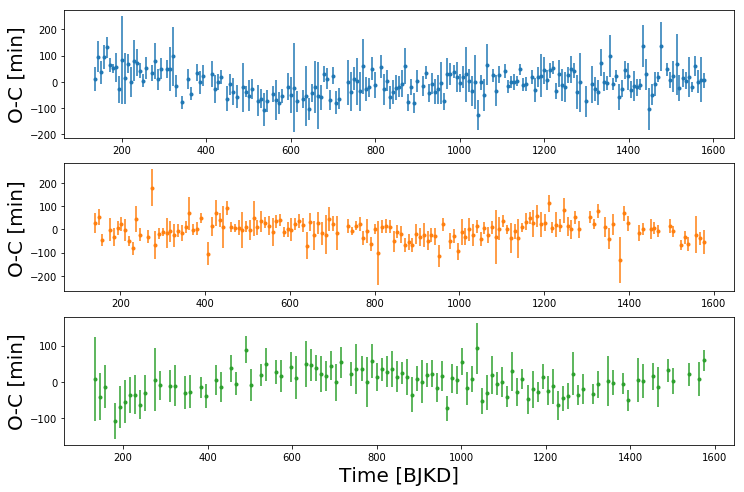

In [49]:
indep_transit_times = []
indep_ephemeris = []
full_indep_ephemeris = []

fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl, p in enumerate(planets):
    inds  = single_inds[npl]
    xtime = single_tts[npl][:,0]
    xerr  = single_tts[npl][:,1]
    ephem = np.polyval(np.polyfit(inds, xtime, 1, w=1/xerr), inds)
    yomc  = (xtime - ephem)*24*60
    
    indep_transit_times.append(xtime)
    indep_ephemeris.append(ephem)
    full_indep_ephemeris.append(np.polyval(np.polyfit(inds, xtime, 1, w=1/xerr), p.index))
    
    
    axes[npl].errorbar(xtime, yomc, yerr=xerr*24*60, fmt='.', color='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
#plt.savefig(FIGURE_DIR + TARGET + '_ttvs_quick.pdf', bbox_inches='tight')
plt.show()

In [51]:
# get estimate of ttv amplitude and a reasonable buffer
ttv_amps   = np.zeros(NPL)
ttv_buffer = np.zeros(NPL)

for npl in range(NPL):
    # estimate TTV amplitude
    ttv_amps[npl] = astropy.stats.mad_std(indep_transit_times[npl] - indep_ephemeris[npl])

    # based on scatter in independent times, set threshold so not even one outlier is expected
    N   = len(transit_inds[npl])
    eta = np.max([3., stats.norm.interval((N-1)/N)[1]])

    ttv_buffer[npl] = eta*ttv_amps[npl]

In [55]:
# Save fixed ephemeris and independent TTV measurements to a text file
for npl in range(NPL):
    data_out  = np.vstack([single_inds[npl], single_tts[npl][:,0], single_tts[npl][:,1]]).swapaxes(0,1)
    fname_out = QUICK_TTV_DIR + TARGET + '_{:02d}'.format(npl) + '_quick_ttvs.txt'
    
    np.savetxt(fname_out, data_out, fmt=('%1d', '%.8f', '%.8f'), delimiter='\t')

In [53]:
print('')
print('cumulative runtime = ', int(timer() - global_start_time), 's')
print('')


cumulative runtime =  9716 s



# Fit a Matern-3/2 kernel GP directly to the independent TTVs


PLANET 0

iteration 1


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, mean, log_rho_off, log_sigma]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:19<00:00, 719.11draws/s]
Sequential sampling (1 chains in 1 job)
NUTS: [tau, mu, w]
100%|██████████| 4000/4000 [00:16<00:00, 240.27it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


loc [-0.00605136]
scale [0.96046346 1.05027287]
7 outliers found out of 180 transit times (4.0%)

iteration 2


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, mean, log_rho_off, log_sigma]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:19<00:00, 700.55draws/s]


BAD FRACTION = 0.0


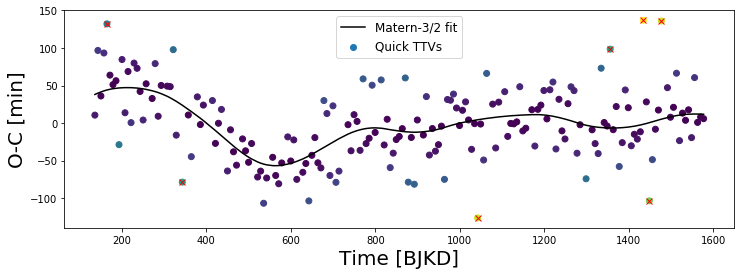


PLANET 1

iteration 1


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, mean, log_rho_off, log_sigma]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:20<00:00, 682.30draws/s] 
Sequential sampling (1 chains in 1 job)
NUTS: [tau, mu, w]
100%|██████████| 4000/4000 [00:09<00:00, 413.26it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


loc [0.02436689]
scale [1.93640115 0.69061126]
22 outliers found out of 145 transit times (15.0%)

iteration 2


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, mean, log_rho_off, log_sigma]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:20<00:00, 676.22draws/s]


BAD FRACTION = 0.0


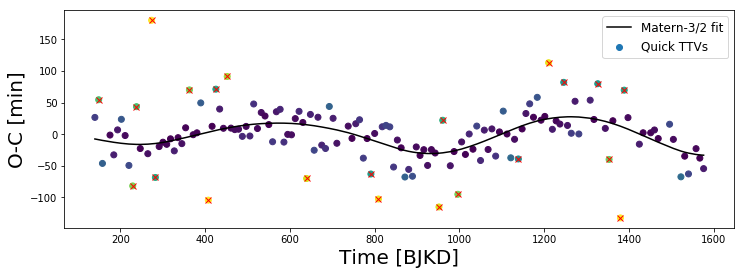


PLANET 2

iteration 1


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, mean, log_rho_off, log_sigma]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:20<00:00, 671.20draws/s]
Sequential sampling (1 chains in 1 job)
NUTS: [tau, mu, w]
100%|██████████| 4000/4000 [00:15<00:00, 253.87it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


loc [-0.00168918]
scale [1.11372717 0.89335911]
5 outliers found out of 100 transit times (5.0%)

iteration 2


Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logvar, mean, log_rho_off, log_sigma]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:16<00:00, 829.07draws/s] 


BAD FRACTION = 0.0


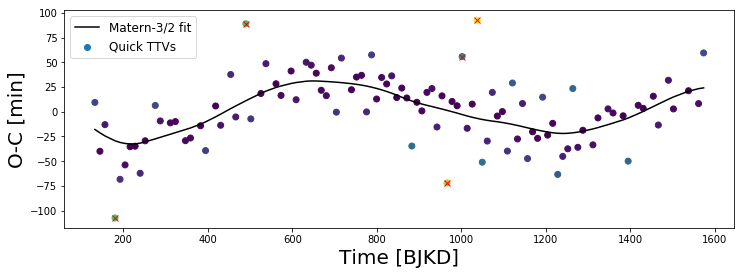

In [50]:
matern_ephemeris = []
matern_transit_times = []

matern_log_sigma = np.zeros((NPL,2))
matern_log_rho = np.zeros((NPL,2))


for npl, p in enumerate(planets):
    print("\nPLANET", npl)
    xtime = indep_ephemeris[npl]
    yomc  = indep_transit_times[npl] - indep_ephemeris[npl]

    ymed = ndimage.median_filter(yomc, size=5, mode="mirror")
    out  = np.abs(yomc-ymed)/astropy.stats.mad_std(yomc-ymed) > 5.0
 

    loop = True
    iteration = 0
    while loop:
        iteration += 1
        print("\niteration", iteration)

        # fit a GP with a Matern-3/2 kernel
        with pm.Model() as matern_model:
            # build the kernel 
            log_sigma = pm.Normal("log_sigma", mu=np.log(np.std(yomc)), sd=10)
            
            log_rho_off = pm.Normal("log_rho_off", mu=np.log(2*periods[npl]), sd=5)
            rho = pm.Deterministic("rho", 4*periods[npl] + T.exp(log_rho_off))
            log_rho = pm.Deterministic("log_rho", T.log(rho))

            kernel = exo.gp.terms.Matern32Term(log_sigma=log_sigma, log_rho=log_rho)

            # nusiance parameters
            mean = pm.Normal("mean", mu=np.mean(yomc), sd=10)
            logvar = pm.Normal("logvar", mu=np.log(np.var(yomc)), sd=10)

            # here's the GP
            gp = exo.gp.GP(kernel, xtime[~out], T.exp(logvar)*T.ones(len(xtime[~out])))

            # add custom potential (log-prob fxn) with the GP likelihood
            pm.Potential("obs", gp.log_likelihood(yomc[~out] - mean))

            # track GP prediction
            gp_pred = pm.Deterministic("gp_pred", gp.predict(indep_ephemeris[npl]))
            
            full_trend = pm.Deterministic("full_trend", mean + gp.predict(full_indep_ephemeris[npl]))
            part_trend = pm.Deterministic("part_trend", mean + gp.predict(indep_ephemeris[npl]))


        with matern_model:
            matern_trace = pm.sample(tune=5000, draws=2000, start=matern_model.test_point, chains=2, 
                                     step=exo.get_dense_nuts_step(target_accept=0.9))

        nbroadcast = len(xtime)
        broadcasted_mean = np.tile(matern_trace["mean"], nbroadcast).reshape(nbroadcast, -1).swapaxes(0,1)
        trend = np.nanmedian(matern_trace["gp_pred"] + broadcasted_mean, 0)

        
        # stop looping if the maximum number of iterations has been reached
        if iteration >= 2:
            loop = False
        
        else:
            # fit a mixture model to the residuals
            res = yomc - trend
            resnorm = res / np.std(res)
            resnorm -= np.mean(resnorm)

            with pm.Model() as mix_model:
                w = pm.Dirichlet("w", np.array([1.,1.]))
                mu = pm.Normal("mu", mu=0.0, sd=5.0, shape=1)
                tau = pm.Gamma("tau", 1.0, 1.0, shape=2)
                obs = pm.NormalMixture("obs", w, mu=mu*T.ones(2), tau=tau, observed=resnorm)

            with mix_model:
                mix_trace = pm.sample(tune=3000, draws=1000, start=mix_model.test_point, chains=1, 
                                      step=exo.get_dense_nuts_step(target_accept=0.9))


            # calculate foreground/background probabilities
            loc = np.nanmedian(mix_trace["mu"], axis=0)
            scale = np.nanmedian(1/np.sqrt(mix_trace["tau"]), axis=0)

            print("loc", loc)
            print("scale", scale)


            order = np.argsort(scale)
            scale = scale[order]

            z_fg = stats.norm(loc=loc, scale=scale[0]).pdf(resnorm)
            z_bg = stats.norm(loc=loc, scale=scale[1]).pdf(resnorm)

            fg_prob = z_fg/(z_fg+z_bg)


            # use KMeans clustering to assign each point to the foreground or background
            km = KMeans(n_clusters=2)
            group = km.fit_predict(fg_prob.reshape(-1,1))
            centroids = np.array([np.mean(fg_prob[group==0]), np.mean(fg_prob[group==1])])

            bad = group == np.argmin(centroids)
            print("{0} outliers found out of {1} transit times ({2}%)".format(np.sum(bad), len(bad), 
                                                                              np.round(100.*np.sum(bad)/len(bad),1)))

            # check for convergence and update outlier flagss
            if np.alltrue(bad == out):
                loop = False

            out = np.copy(bad)
        

    # save the final results
    mtts = full_indep_ephemeris[npl] + np.nanmedian(matern_trace["full_trend"], 0)
    mephem = np.polyval(np.polyfit(p.index, mtts, 1), p.index)
                                                                          
    matern_transit_times.append(mtts)
    matern_ephemeris.append(mephem)   
       
    matern_log_sigma[npl] = np.nanmedian(matern_trace["log_sigma"]), np.std(matern_trace["log_sigma"])
    matern_log_rho[npl] = np.nanmedian(matern_trace["log_rho"]), np.std(matern_trace["log_rho"])

    

    print("BAD FRACTION =", np.sum(np.isnan(matern_trace["gp_pred"]))/np.size(matern_trace["gp_pred"]))
    
    
    # plot the final trend and outliers
    plt.figure(figsize=(12,4))
    plt.scatter(xtime, yomc*24*60, c=1-fg_prob, cmap="viridis", label="Quick TTVs")
    plt.plot(xtime[bad], yomc[bad]*24*60, "rx")
    plt.plot(xtime, np.nanmedian(matern_trace["part_trend"],0)*24*60, "k", label="Matern-3/2 fit")
    plt.xlabel("Time [BJKD]", fontsize=20)
    plt.ylabel("O-C [min]", fontsize=20)
    plt.legend(fontsize=12)
    plt.show()    

In [ ]:
for npl, p in enumerate(planets):
    p.tts = np.copy(matern_transit_times[npl])

# Detrend again with better estimates of transit timing

In [ ]:
# reset to raw data

if MISSION == 'Kepler':
    try:
        sc_data = detrend.cleanup_lkfc(sc_rawdata, KIC)

        sc_quarters = []
        for i, scd in enumerate(sc_data):
            sc_quarters.append(scd.quarter)    
    
    except:
        pass
    
    
    try:
        lc_data = detrend.cleanup_lkfc(lc_rawdata, KIC)

        lc_quarters = []
        for i, lcd in enumerate(lc_data):
            lc_quarters.append(lcd.quarter)
            
    except:
        pass
        

        
elif MISSION == 'Simulated':
    sc_quarters = []
    for i, scrd in enumerate(sc_rawdata):
        sc_quarters.append(scrd.quarter)
        
    order = np.argsort(sc_quarters)    
    sc_data = lk.LightCurveCollection([sc_rawdata_list[o] for o in order])
            

    lc_quarters = []
    for i, lcrd in enumerate(lc_rawdata):
        lc_quarters.append(lcrd.quarter)
        
    order = np.argsort(lc_quarters)    
    lc_data = lk.LightCurveCollection([lc_rawdata_list[o] for o in order])

In [ ]:
# clean up the LONG CADENCE data
for i, lcq in enumerate(lc_data):
    lcq = detrend.remove_flagged_cadences(lcq)
    lcq = detrend.clip_outliers(lcq, kernel_size=13, sigma_upper=5.0, sigma_lower=5.0)
    lc_data[i] = lcq

# broadcast quarter and channel integers into arrays (for convenient use after stitching)
for i, lcq in enumerate(lc_data):
    lcq.quarter = lcq.quarter*np.ones(len(lcq.time))
    lcq.channel = lcq.channel*np.ones(len(lcq.time))

    
if len(lc_data) > 0:
    # combine quarters into a single LiteCurve
    lc = detrend.stitch_lkc(lc_data)
    
    # make a mask where planets transit
    lc_mask = np.zeros((NPL,len(lc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        masksize = (p.duration + 2*ttv_buffer[npl] + 1/24) / p.duration / 2
        masksize = np.max([masksize, 2/3])
    
        lc_mask[npl] = detrend.make_transitmask(lc.time, p.tts, p.duration, masksize=masksize)

    lc.mask = deepcopy(lc_mask)
    
    # plot the non-detrended data
    plt.figure(figsize=(20,4))
    plt.plot(lc.time, lc.flux, c="k", lw=0.5)
    plt.xlim(lc.time.min(), lc.time.max())
    plt.show()
    
else:
    lc = None

In [ ]:
if lc is not None:    
    # detrend
    break_tolerance = int(DURS.max()/(LCIT/60/24)*5/2)
    min_period = 5*DURS.max()
    
    lc = detrend.flatten_with_gp(lc, break_tolerance=break_tolerance, min_period=min_period)

    # determine seasons
    lc.season = lc.quarter % 4

    # plot detrended data
    plt.figure(figsize=(16,4))
    plt.plot(lc.time, lc.flux, c='k', lw=0.5)
    plt.xlim(lc.time.min(), lc.time.max())
    plt.xlabel('Time [BKJD]', fontsize=20)
    plt.ylabel('Relative Flux', fontsize=20)
    plt.savefig(FIGURE_DIR + TARGET + '_long_cadence_flux.pdf', bbox_inches='tight')
    plt.show()

In [ ]:
# clean up the SHORT CADENCE data
for i, scq in enumerate(sc_data):
    scq = detrend.remove_flagged_cadences(scq)
    scq = detrend.clip_outliers(scq, kernel_size=13, sigma_upper=5.0, sigma_lower=5.0)
    sc_data[i] = scq

# broadcast quarter and channel integers into arrays (for convenient use after stitching)
for i, scq in enumerate(sc_data):
    scq.quarter = scq.quarter*np.ones(len(scq.time))
    scq.channel = scq.channel*np.ones(len(scq.time))

    
if len(sc_data) > 0:
    # combine quarters into a single LiteCurve
    sc = detrend.stitch_lkc(sc_data)
    
    # make a mask where planets transit
    sc_mask = np.zeros((NPL,len(sc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        masksize = (p.duration + 2*ttv_buffer[npl] + 1/24) / p.duration / 2
        masksize = np.max([masksize, 2/3])

        sc_mask[npl] = detrend.make_transitmask(sc.time, p.tts, p.duration, masksize=masksize)

    sc.mask = deepcopy(sc_mask)
    
    # plot the non-detrended data
    plt.figure(figsize=(20,4))
    plt.plot(sc.time, sc.flux, c="k", lw=0.5)
    plt.xlim(sc.time.min(), sc.time.max())
    plt.show()
    
else:
    sc = None

In [ ]:
if sc is not None:    
    # detrend
    break_tolerance = int(DURS.max()/(SCIT/3600/24)*5/2)
    min_period = 5*DURS.max()
    
    sc = detrend.flatten_with_gp(sc, break_tolerance=break_tolerance, min_period=min_period)

    # determine seasons
    sc.season = sc.quarter % 4

    # plot detrended data
    plt.figure(figsize=(16,4))
    plt.plot(sc.time, sc.flux, c='k', lw=0.5)
    plt.xlim(sc.time.min(), sc.time.max())
    plt.xlabel('Time [BKJD]', fontsize=20)
    plt.ylabel('Relative Flux', fontsize=20)
    plt.savefig(FIGURE_DIR + TARGET + '_short_cadence_flux.pdf', bbox_inches='tight')
    plt.show()

# Make individual mask for where each planet transits
### These masks have width 1.5 transit durations, which may be wider than the masks used for detrending

In [ ]:
print('Making transit masks')
try:
    sc_mask = np.zeros((NPL,len(sc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        sc_mask[npl] = detrend.make_transitmask(sc.time, p.tts, p.duration, masksize=1.5)

    sc.mask = sc_mask

except:
    sc_mask = None

    
try:
    lc_mask = np.zeros((NPL,len(lc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        lc_mask[npl] = detrend.make_transitmask(lc.time, p.tts, p.duration, masksize=1.5)
    
    lc.mask = lc_mask

except:
    lc_mask = None

# Flag which transits have photometry coverage (quality = 1)

In [ ]:
for npl, p in enumerate(planets):

    quality = []

    # cut out the stamps
    for i, t0 in enumerate(p.tts):
        try:
            neartransit_sc = np.abs(sc.time - t0)/p.duration < 1.5
            neartransit_lc = np.abs(lc.time - t0)/p.duration < 1.5
        
            quality.append((np.sum(neartransit_sc) + np.sum(neartransit_lc)) > 0)
                        
        except:
            neartransit = np.abs(lc.time - t0)/p.duration < 1.5
            quality.append(np.sum(neartransit) > 0)
        
    p.quality = np.copy(quality)

# Flag which transits overlap (overlap = 1)

In [ ]:
# identify overlapping transits
dur_max = np.max(DURS)
overlap = []

for i in range(NPL):
    overlap.append(np.zeros(len(planets[i].tts), dtype='bool'))
    
    for j in range(NPL):
        if i != j:
            for ttj in planets[j].tts:
                overlap[i] += np.abs(planets[i].tts - ttj) < dur_max
                
    planets[i].overlap = np.copy(overlap[i])

# Count up transits and calculate initial fixed transit times

In [ ]:
num_transits  = np.zeros(NPL)
transit_inds  = []
fixed_tts = []

for npl, p in enumerate(planets):
    transit_inds.append((p.index - p.index.min())[p.quality])
    fixed_tts.append(np.copy(p.tts)[p.quality])
    
    num_transits[npl] = len(transit_inds[npl])

# Grab the relevant data and starting transit parameters

In [ ]:
# grab data near transits for each quarter
all_time = []
all_flux = []
all_error = []
all_dtype = []

lc_flux = []
sc_flux = []

if sc is not None:
    for q in range(18):
        if np.isin(q, sc.quarter)*np.isin(q, lc.quarter):
            raise ValueError("Double counting data in both short and long cadence")


        elif np.isin(q, sc.quarter):
            use = (sc.mask.sum(axis=0) > 0)*(sc.quarter == q)

            if np.sum(use) > 45:
                all_time.append(sc.time[use])
                all_flux.append(sc.flux[use])
                all_error.append(sc.error[use])
                all_dtype.append('short')

                sc_flux.append(sc.flux[use])
                
            else:
                all_time.append(None)
                all_flux.append(None)
                all_error.append(None)
                all_dtype.append('none')


        elif np.isin(q, lc.quarter):
            use = (lc.mask.sum(axis=0) > 0)*(lc.quarter == q)
            
            if np.sum(use) > 3:
                all_time.append(lc.time[use])
                all_flux.append(lc.flux[use])
                all_error.append(lc.error[use])
                all_dtype.append('long')

                lc_flux.append(lc.flux[use])
                
            else:
                all_time.append(None)
                all_flux.append(None)
                all_error.append(None)
                all_dtype.append('none')


        else:
            all_time.append(None)
            all_flux.append(None)
            all_error.append(None)
            all_dtype.append('none')
            
else:
    for q in range(18):
        if np.isin(q, lc.quarter):
            use = (lc.mask.sum(axis=0) > 0)*(lc.quarter == q)

            if np.sum(use) > 3:
                all_time.append(lc.time[use])
                all_flux.append(lc.flux[use])
                all_error.append(lc.error[use])
                all_dtype.append('long')

                lc_flux.append(lc.flux[use])
                
            else:
                all_time.append(None)
                all_flux.append(None)
                all_error.append(None)
                all_dtype.append('none')


        else:
            all_time.append(None)
            all_flux.append(None)
            all_error.append(None)
            all_dtype.append('none')



# check which quarters have data
good = (np.array(all_dtype) == 'short') + (np.array(all_dtype) == 'long')
quarters = np.arange(18)[good]
nq = len(quarters)


# make some linear flux arrays (for convenience use laster)
try: sc_flux_lin = np.hstack(sc_flux)
except: sc_flux_lin = np.array([])
    
try: lc_flux_lin = np.hstack(lc_flux)
except: lc_flux_lin = np.array([])
    
try:
    good_flux = np.hstack([sc_flux_lin, lc_flux_lin])
except:
    try:
        good_flux = np.hstack(sc_flux)
    except:
        good_flux = np.hstack(lc_flux)

In [ ]:
# pull basic transit parameters
epochs    = np.zeros(NPL)
periods   = np.zeros(NPL)
depths    = np.zeros(NPL)
durations = np.zeros(NPL)
impacts   = np.zeros(NPL)

for npl, p in enumerate(planets):
    epochs[npl]    = p.epoch
    periods[npl]   = p.period
    depths[npl]    = p.depth
    durations[npl] = p.duration
    impacts[npl]   = p.impact

radii = np.sqrt(depths)*RSTAR

In [ ]:
print('')
print('cumulative runtime = ', int(timer() - global_start_time), 's')
print('')

# Make individual mask for where each planet transits
### These masks have width 1.5 transit durations, which may be wider than the masks used for detrending

In [ ]:
print('Making transit masks')
try:
    sc_mask = np.zeros((NPL,len(sc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        sc_mask[npl] = detrend.make_transitmask(sc.time, p.tts, p.duration, masksize=1.5)

    sc.mask = sc_mask

except:
    sc_mask = None

    
try:
    lc_mask = np.zeros((NPL,len(lc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        lc_mask[npl] = detrend.make_transitmask(lc.time, p.tts, p.duration, masksize=1.5)
    
    lc.mask = lc_mask

except:
    lc_mask = None

# Flag where there is data near transit (quality = 1)

In [ ]:
for npl, p in enumerate(planets):

    quality = []

    # cut out the stamps
    for i, t0 in enumerate(p.tts):
        try:
            neartransit_sc = np.abs(sc.time - t0)/p.duration < 1.5
            neartransit_lc = np.abs(lc.time - t0)/p.duration < 1.5
        
            quality.append((np.sum(neartransit_sc) + np.sum(neartransit_lc)) > 0)
                        
        except:
            neartransit = np.abs(lc.time - t0)/p.duration < 1.5
            quality.append(np.sum(neartransit) > 0)
        
    p.quality = np.copy(quality)

In [ ]:
print('')
print('cumulative runtime = ', int(timer() - global_start_time), 's')
print('')

# Make phase-folded transit plots

In [ ]:
for npl, p in enumerate(planets):
    tts = p.tts[p.quality*~p.overlap]
    
    
    if len(tts) == 0:
        print("No non-overlapping high quality transits found for planet {0} (P = {1} d)".format(npl, p.period))
    
    
    else:
        t_ = []
        f_ = []


        for t0 in tts:
            try:
                neartransit_sc = np.abs(sc.time - t0)/p.duration < 1.5
            except:
                neartransit_sc = None

            try:
                neartransit_lc = np.abs(lc.time - t0)/p.duration < 1.5
            except:
                neartransit_lc = None

            if (neartransit_lc is not None) and (np.sum(neartransit_lc) > 0):
                t_.append(lc.time[neartransit_lc] - t0)
                f_.append(lc.flux[neartransit_lc])

            if (neartransit_sc is not None) and (np.sum(neartransit_sc) > 0):
                t_.append(sc.time[neartransit_sc] - t0)
                f_.append(sc.flux[neartransit_sc])


        t_ = np.hstack(t_)
        f_ = np.hstack(f_)

        order = np.argsort(t_)
        t_ = t_[order]
        f_ = f_[order]

        f_bin = bin_data(t_, f_, LCIT/60/24/2)
        t_bin = bin_data(t_, t_, LCIT/60/24/2)

        plt.figure(figsize=(12,4))
        plt.plot(t_*24, f_, ".", c="lightgrey")
        plt.plot(t_bin*24, f_bin, "o", ms=5, color="C{0}".format(npl))
        plt.savefig(FIGURE_DIR + TARGET + '_{0:02d}_folded_transit_.pdf'.format(npl), bbox_inches='tight')
        plt.show()

# Generate and model empirical autocorrelation function (ACF)

In [ ]:
# generating figures inside imported modules creates issues with UChicago Midway RCC cluster
# it's easier to just define the function here in the main script

def plot_acf(xcor, acf_emp, acf_mod, xf, yf, freqs, target_name, season):
    """
    Docstring
    """
    fig = plt.figure(figsize=(20,5))

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.8)

    ax = plt.subplot2grid(shape=(5,10), loc=(0,0), rowspan=3, colspan=7)
    ax.plot(xcor*24, acf_emp[0], color='lightgrey')
    ax.plot(xcor*24, acf_mod[0], c='red')
    ax.set_xlim(xcor.min()*24,xcor.max()*24)
    ax.set_xticks(np.arange(0,xcor.max()*24,2))
    ax.set_xticklabels([])
    ax.set_ylim(acf_emp.min()*1.1, acf_emp.max()*1.1)
    ax.set_ylabel('ACF', fontsize=20)
    ax.text(xcor.max()*24-0.15, acf_emp.max(), '%s, SEASON %d' %(target_name, season), va='top', ha='right', fontsize=20)


    ax = plt.subplot2grid(shape=(5,10), loc=(0,7), rowspan=5, colspan=3)
    ax.plot(xf/24/3600*1e3, yf, color='k', lw=0.5)
    for f in freqs:
        ax.axvline(f/24/3600*1e3, color='red', zorder=0, lw=3, alpha=0.3) 
    ax.set_xlim(xf.min()/24/3600*1e3, xf.max()/24/3600*1e3)
    ax.set_ylim(yf.min(),1.2*yf.max())
    ax.set_ylabel('Power', fontsize=20)
    ax.set_yticks([])
    ax.set_xlabel('Frequency [mHz]', fontsize=20)

    for i, sf in enumerate(np.sort(freqs)[::-1]):
        ax.text(xf.min()/24/3600*1e3+0.1, yf.max()*(1.1-0.1*i), '%.2f min' %(24*60/sf), fontsize=16)


    ax = plt.subplot2grid(shape=(5,10), loc=(3,0), rowspan=2, colspan=7)
    ax.plot(xcor*24, acf_emp[1], c='lightgrey')
    #ax.plot(xcor*24, acf_mod[1], c='red', lw=0.5)
    ax.set_xlim(xcor.min()*24,xcor.max()*24)
    ax.set_xticks(np.arange(0,xcor.max()*24,2))
    ax.set_xlabel('Lag time [hours]', fontsize=20)
    ax.set_ylabel('Residuals', fontsize=20)    
    
    return fig

In [ ]:
print('Generating autocorrelation function\n')

# set Npts from 5 x maximum transit duration
durations = np.zeros(NPL)
for npl, p in enumerate(planets):
    durations[npl] = p.duration
Npts = int(5*durations.max()*24*3600/SCIT)


# set cutoff between low and high frequency signals
fcut = 2/(LCIT/60/24)
fmin = 2/(5*durations.max())

# now estimate the ACF
acf_lag = []
acf_emp = []
acf_mod = []
acf_freqs = []


if sc is not None:
    for z in range(4):
        # make a mask where any planet transits
        scm = sc.mask.sum(axis=0) > 0

        # pull out a particular season
        use = sc.season == z
        scm = scm[use]

        if np.sum(use) > 0:
            sc_time = sc.time[use][~scm]
            sc_flux = sc.flux[use][~scm]
            sc_error = sc.error[use][~scm]
            sc_cadno = sc.cadno[use][~scm]

            # generate the empirical acf
            xcor, acor, wcor, acf_stats = noise.generate_acf(sc_time, sc_flux, sc_cadno, Npts)

            # model the acf
            acor_emp, acor_mod, xf, yf, freqs = noise.model_acf(xcor, acor, fcut, fmin=fmin, method='savgol')

            # make some plots
            fig = plot_acf(xcor, acor_emp, acor_mod, xf, yf, freqs, TARGET, z)
            fig.savefig(FIGURE_DIR + TARGET + '_ACF_season_{0}.pdf'.format(z), bbox_inches='tight')


            # filter out significant high-frequency components
            fring = freqs[freqs > fcut]
            bw = 1/(lcit-scit/np.sqrt(2))-1/(lcit+scit/np.sqrt(2))

            if len(fring) > 0:
                flux_filtered = detrend.filter_ringing(sc, break_tolerance, fring, bw)

                sc.flux[use] = flux_filtered[use]
                sc_flux = sc.flux[use][~scm]


            # re-run the ACF modeling on the filtered lightcurve
            xcor, acor, wcor, acf_stats = noise.generate_acf(sc_time, sc_flux, sc_cadno, Npts)
            acor_emp, acor_mod, xf, yf, freqs = noise.model_acf(xcor, acor, fcut, fmin=fmin, method='savgol')

            fig = plot_acf(xcor, acor_emp, acor_mod, xf, yf, freqs, TARGET, z)
            fig.savefig(FIGURE_DIR + TARGET + '_ACF_season_{0}_filtered.pdf'.format(z), bbox_inches='tight')


            # add to list
            acf_lag.append(xcor)
            acf_emp.append(acor_emp)
            acf_mod.append(acor_mod)
            acf_freqs.append(freqs)        


        else:
            acf_lag.append(None)
            acf_emp.append(None)
            acf_mod.append(None)
            acf_freqs.append(None)

# Generate synthetic noise

In [ ]:
print('Generating synthetic noise\n')

synth_time  = []
synth_red   = []
synth_white = []

if sc is not None:
    for z in range(4):
        # make a mask where any planet transits
        scm = sc.mask.sum(axis=0) > 0

        # pull out a particular season
        use = sc.season == z
        scm = scm[use]

        if np.sum(use) > 0:
            sc_time = sc.time[use][~scm]
            sc_flux = sc.flux[use][~scm]
            sc_error = sc.error[use][~scm]
            sc_cadno = sc.cadno[use][~scm]

            # pull and split high/low frequencies
            freqs = acf_freqs[z]

            low_freqs  = freqs[freqs <= fcut]
            high_freqs = freqs[freqs > fcut]

            # generate some synthetic correlated noise
            x, red_noise, white_noise = noise.generate_synthetic_noise(acf_lag[z], acf_mod[z][0]+acf_mod[z][1], 
                                                                       5*len(acf_lag[z]), np.median(sc_error))

            # add to list
            synth_time.append(x)
            synth_red.append(red_noise)
            synth_white.append(white_noise)

            # plot the noise
            plt.figure(figsize=(20,8))
            plt.plot(x, white_noise + red_noise, '.', c='lightgrey')
            plt.plot(x, red_noise, c='red', lw=4)
            plt.axhline(0.0005, c='k', ls='--', lw=3)
            plt.axhline(-0.0005, c='k', ls='--', lw=3)
            plt.xlim(x.min(),x.max())
            plt.xlabel('Time [days]', fontsize=30)
            plt.ylabel('Flux', fontsize=30)
            plt.text(x.max()-0.02, white_noise.max(), '%s, SEASON %d' %(TARGET, z), va='center', ha='right', fontsize=24)
            plt.savefig(FIGURE_DIR + TARGET + '_synthetic_noise_season_{0}.pdf'.format(z), bbox_inches='tight')
            plt.show()

        else:
            synth_time.append(None)
            synth_red.append(None)
            synth_white.append(None)

# Fit a GP to the synthetic noise

In [ ]:
print('Fitting a GP to synthetic noise\n')

gp_model  = []
gp_trace  = []
gp_priors = []

if sc is not None:
    for z in range(4):
        # make a mask where any planet transits
        scm = sc.mask.sum(axis=0) > 0

        # pull out a particular season
        use = sc.season == z
        scm = scm[use]

        if np.sum(use) > 0:
            sc_time = sc.time[use][~scm]
            sc_flux = sc.flux[use][~scm]
            sc_error = sc.error[use][~scm]
            sc_cadno = sc.cadno[use][~scm]

            # pull out and split high/low frequencies
            freqs = acf_freqs[z]

            low_freqs  = freqs[freqs <= fcut]
            high_freqs = freqs[freqs > fcut]

            if len(low_freqs) > 0:
                lf = [low_freqs[0]]
                extra_term = None
            else:
                lf = None
                extra_term = 'free'

            if len(high_freqs) > 0:
                warnings.warn("there are remaining high-frequency noise components")


            # fit a GP model to the synthetic noise
            gp_model.append(noise.build_sho_model(synth_time[z], synth_red[z], var_method='local', \
                                                  low_freqs=lf, high_freqs=None, extra_term=extra_term))

        else:
            gp_model.append(None)


        if np.sum(use) > 0:
            with gp_model[z] as model:
                map_soln = exo.optimize(start=model.test_point, vars=[model.vars[0]])

                for mv in model.vars[1:]:
                    map_soln = exo.optimize(start=map_soln, vars=[mv])

                map_soln = exo.optimize(start=map_soln)


            with gp_model[z] as model:
                trace = pm.sample(tune=2000, draws=500, start=map_soln, chains=2, \
                                  step=exo.get_dense_nuts_step(target_accept=0.9))

            plt.figure(figsize=(20,4))
            plt.plot(synth_time[z], synth_red[z], c='pink', lw=4)
            plt.plot(synth_time[z], np.nanmedian(trace['gp_pred'], axis=0), c='red')
            plt.xlim(synth_time[z].min(), synth_time[z].max())
            plt.savefig(FIGURE_DIR + TARGET + '_GP_noise_model_{0}.pdf'.format(z), bbox_inches='tight')
            plt.show()

            # transfer trace posteriors to new prior dictionary
            gp_trace.append(trace)
            gp_priors.append(noise.make_gp_prior_dict(trace))


        else:
            gp_trace.append(None)
            gp_priors.append(None)


    # save the GP trace results
    gp_var_names=['logw0', 'logSw4', 'logQ', 'logw0_x', 'logSw4_x', 'logQ_x', 'logS1', 'logS2', 'logQ1']

    for i, gpt in enumerate(gp_trace):
        if gpt is not None:
            varnames = np.array(gpt.varnames)[np.isin(gpt.varnames, gp_var_names)]    

            hdulist = io.trace_to_hdulist(gpt, varnames, TARGET)
            hdulist.writeto(TRACE_DIR + TARGET + '_gp_{0}.fits'.format(i), overwrite=True)

In [ ]:
if sc is not None:
    do_plots = False
    if do_plots:
        for z, gpt in enumerate(gp_trace):
            print(z)
            try:
                varnames = np.array(gpt.varnames)[np.isin(gpt.varnames, gp_var_names)]

                with gp_model[z]:
                    pm.traceplot(gp_trace[z], var_names=varnames)

            except:
                pass

In [ ]:
# list of all quarters with data
quarters = np.sort(np.hstack([lc_quarters, sc_quarters]))

# get variance of each quarter
if lc is not None:
    lcm = lc.mask.sum(axis=0) == 0
if sc is not None:
    scm = sc.mask.sum(axis=0) == 0

var_by_quarter = []

for i, q in enumerate(quarters):
    if (sc is not None) and (np.sum(sc.quarter==q) > 0):
        var_by_quarter.append(np.var(sc.flux[scm*(sc.quarter==q)]))
    elif (lc is not None) and (np.sum(lc.quarter==q) > 0):
        var_by_quarter.append(np.var(lc.flux[lcm*lc.quarter==q]))
    else:
        var_by_quarter.append(None)

# Save detrended lightcurves and estimates of the noise properties

In [ ]:
# Save detrended lightcurves as .fits files
try:
    lc.to_fits(TARGET, DLC_DIR + TARGET + '_lc_detrended.fits')
except:
    print("No long cadence data")

try:
    sc.to_fits(TARGET, DLC_DIR + TARGET + '_sc_detrended.fits')
except:
    print("No short cadence data")

In [ ]:
# Save var_by_quarter
data_out  = np.vstack([quarters, var_by_quarter]).swapaxes(0,1)
fname_out = NOISE_DIR + TARGET + '_var_by_quarter.txt'
    
np.savetxt(fname_out, data_out, fmt=('%1d', '%.15f'), delimiter='\t')


# save gp_priors
for z in range(4):
    try:
        for k in gp_priors[z].keys():
            gp_priors[z][k] = list(gp_priors[z][k])

        fname_out = NOISE_DIR + TARGET + '_shoterm_gp_priors_{0}.txt'.format(z)

        with open(fname_out, 'w') as file:
            json.dump(gp_priors[z], file)
            
    except:
        pass

In [ ]:
print('TOTAL RUNTIME = %.2f min' %((timer()-global_start_time)/60))